<h2 id="problem_statement">1. Problem Statement</h2>

### What is the major factors affecting bike rentals

To predict:
* Bike Rentals so as to enable planning to efficiently allocate resources effectively

In this notebook, we'll focus on *regression*, using an example based on a real study in which data for a bicycle sharing scheme was collected and used to predict the number of rentals based on seasonality and weather conditions. We'll use a simplified version of the dataset from that study.

> **Citation**: The data used in this exercise is derived from [Capital Bikeshare](https://www.capitalbikeshare.com/system-data) and is used in accordance with the published [license agreement](https://www.capitalbikeshare.com/data-license-agreement).

## Explore the Data

The first step in any machine learning project is to explore the data that you will use to train a model. The goal of this exploration is to try to understand the relationships between its attributes; in particular, any apparent correlation between the *features* and the *label* your model will try to predict. This may require some work to detect and fix issues in the data (such as dealing with missing values, errors, or outlier values), deriving new feature columns by transforming or combining existing features (a process known as *feature engineering*), *normalizing* numeric features (values you can measure or count) so they're on a similar scale, and *encoding* categorical features (values that represent discrete categories) as numeric indicators.

Let's start by loading the bicycle sharing data as a **Pandas** DataFrame and viewing the first few rows.

First lets load needed libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [3]:
# load the training dataset
path= "https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/daily-bike-share.csv"
bike_data = pd.read_csv(path)

In [4]:
## lets save the dataset and recall it
bike_data.to_csv('bike_data.csv')

In [5]:
df = pd.read_csv("bike_data.csv")
df.head()

,Unnamed: 0,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82


The data consists of the following columns:

- **instant**: A unique row identifier
- **dteday**: The date on which the data was observed - in this case, the data was collected daily; so there's one row per date.
- **season**: A numerically encoded value indicating the season (1:winter, 2:spring, 3:summer, 4:fall)
- **yr**: The year of the study in which the observation was made (the study took place over two years - year 0 represents 2011, and year 1 represents 2012)
- **mnth**: The calendar month in which the observation was made (1:January ... 12:December)
- **holiday**: A binary value indicating whether or not the observation was made on a public holiday)
- **weekday**: The day of the week on which the observation was made (0:Sunday ... 6:Saturday)
- **workingday**: A binary value indicating whether or not the day is a working day (not a weekend or holiday)
- **weathersit**: A categorical value indicating the weather situation (1:clear, 2:mist/cloud, 3:light rain/snow, 4:heavy rain/hail/snow/fog)
- **temp**: The temperature in celsius (normalized)
- **atemp**: The apparent ("feels-like") temperature in celsius (normalized)
- **hum**: The humidity level (normalized)
- **windspeed**: The windspeed (normalized)
- **rentals**: The number of bicycle rentals recorded.

In this dataset, **rentals** represents the label (the *y* value) our model must be trained to predict. The other columns are potential features (*x* values).

As mentioned previously, you can perform some *feature engineering* to combine or derive new features. For example, let's add a new column named **day** to the dataframe by extracting the day component from the existing **dteday** column. The new column represents the day of the month from 1 to 31.

Dropping irrelevant columns

In [6]:
df.drop(['Unnamed: 0','instant'],axis=1, inplace=True)
df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82


In [7]:
## Feature Engineer

## lets add a day column
df['day'] = pd.DatetimeIndex(df['dteday']).day
df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals,day
0,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,1
1,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,2
2,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,3
3,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,4
4,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,5


In [8]:
## We can now drop the 'dteday' column as we have extracted the 'Year', 'Month' and 'Day'
df.drop('dteday',axis=1, inplace=True)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals,day
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,1
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,2
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,3
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,4
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,5


In [9]:
df.shape

(731, 13)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   yr          731 non-null    int64  
 2   mnth        731 non-null    int64  
 3   holiday     731 non-null    int64  
 4   weekday     731 non-null    int64  
 5   workingday  731 non-null    int64  
 6   weathersit  731 non-null    int64  
 7   temp        731 non-null    float64
 8   atemp       731 non-null    float64
 9   hum         731 non-null    float64
 10  windspeed   731 non-null    float64
 11  rentals     731 non-null    int64  
 12  day         731 non-null    int64  
dtypes: float64(4), int64(9)
memory usage: 74.4 KB


In [11]:
df.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
rentals       0
day           0
dtype: int64

In [12]:
df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals,day
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,15.738714
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,8.809949
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,1.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,8.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,16.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,23.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,31.000000


In [13]:
df.corr()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals,day
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,0.210399,-0.000861
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,0.248546,0.002061
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,0.123006,0.009157
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.054274,-0.010710
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.059923,-0.000428
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.518044,0.009907
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,-0.247353,-0.023824
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,0.543285,0.024253
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,0.543864,0.018286
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.077008,0.042753


### Numeric Distribution

In [14]:
numCols = df.select_dtypes([np.number]).columns.drop("rentals")
numCols

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day'],
      dtype='object')

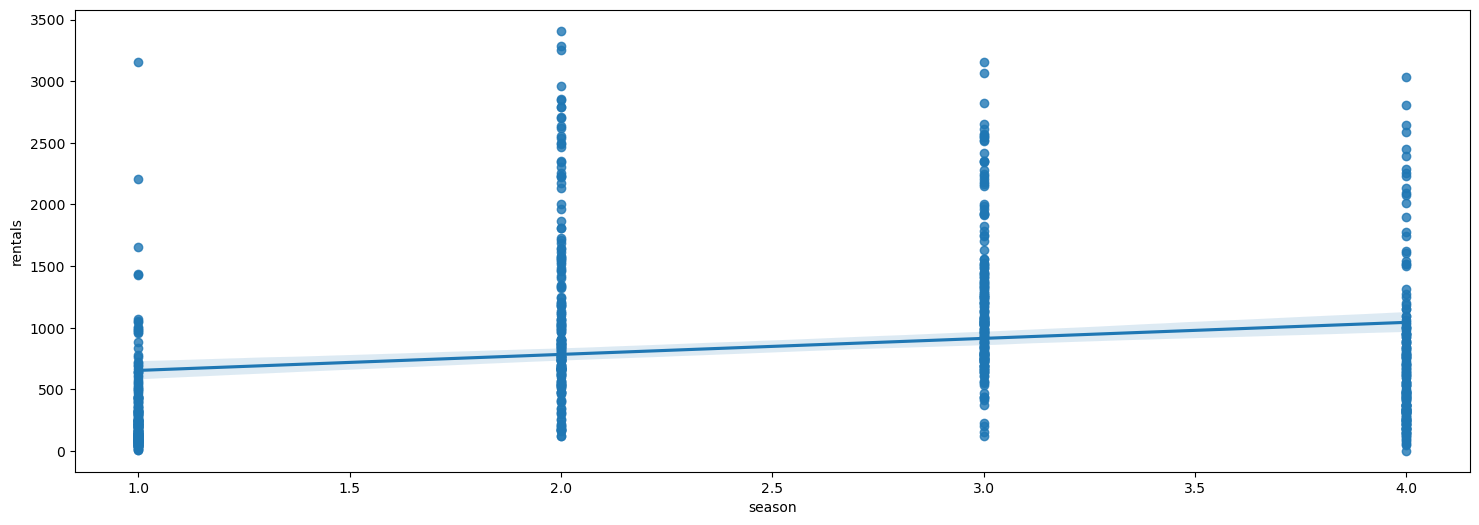

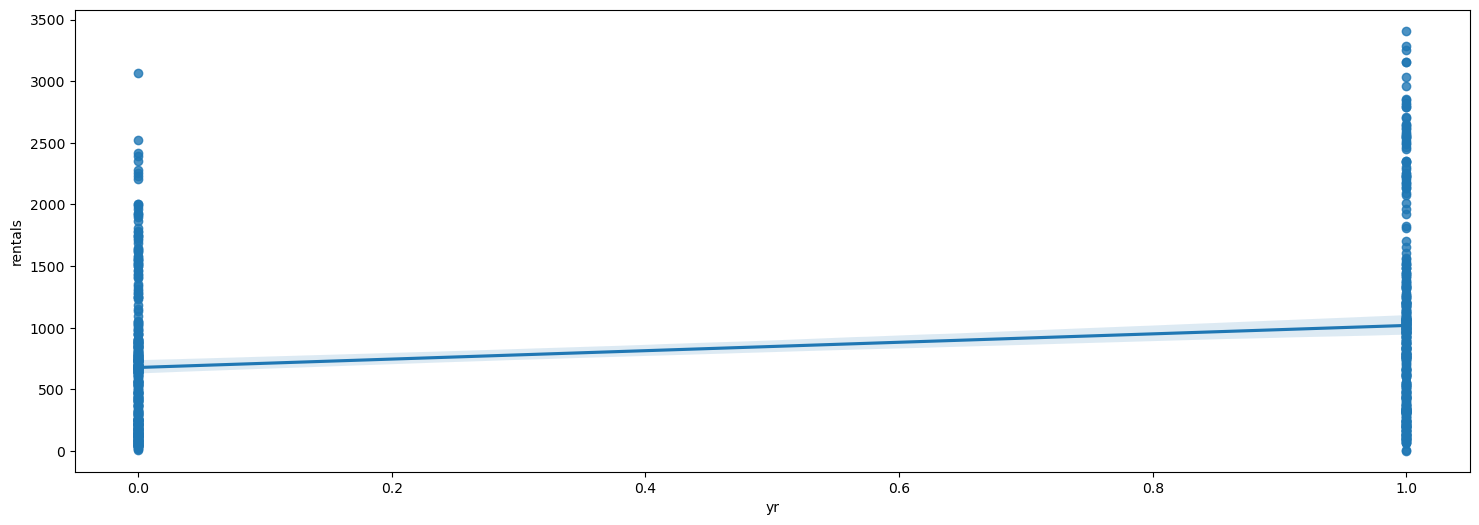

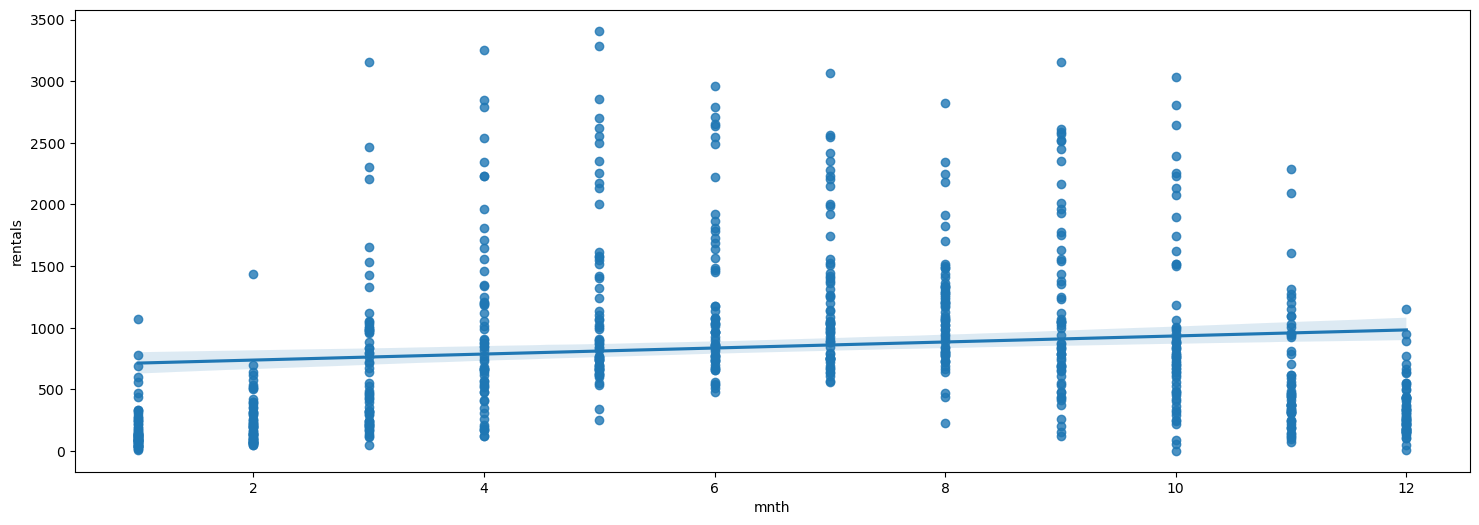

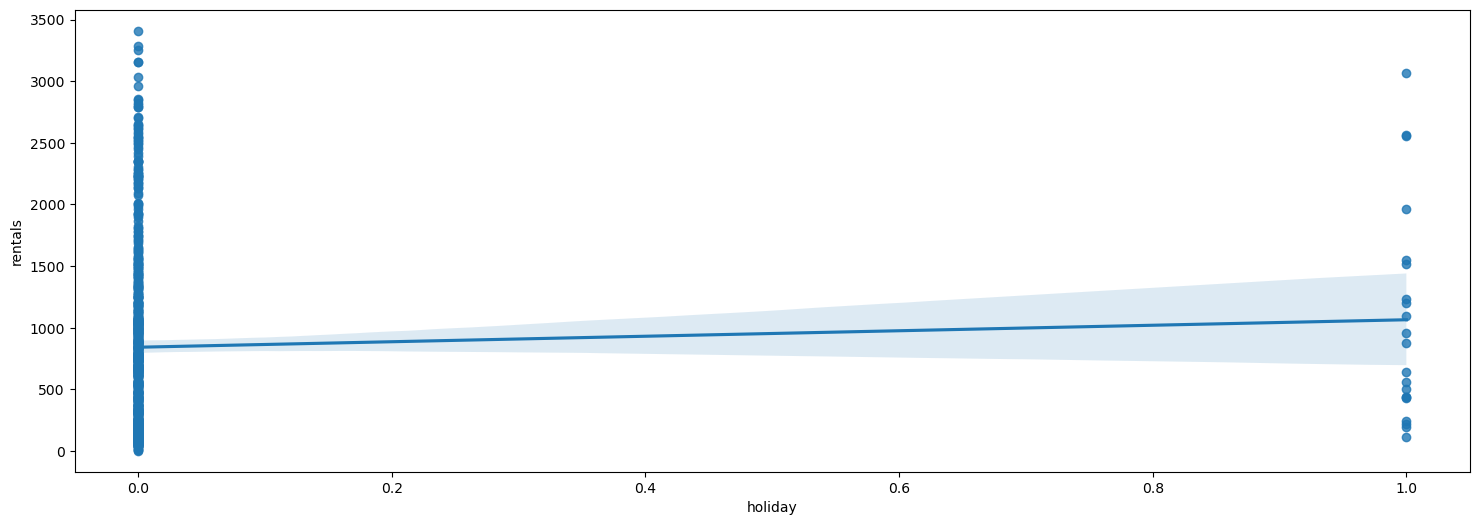

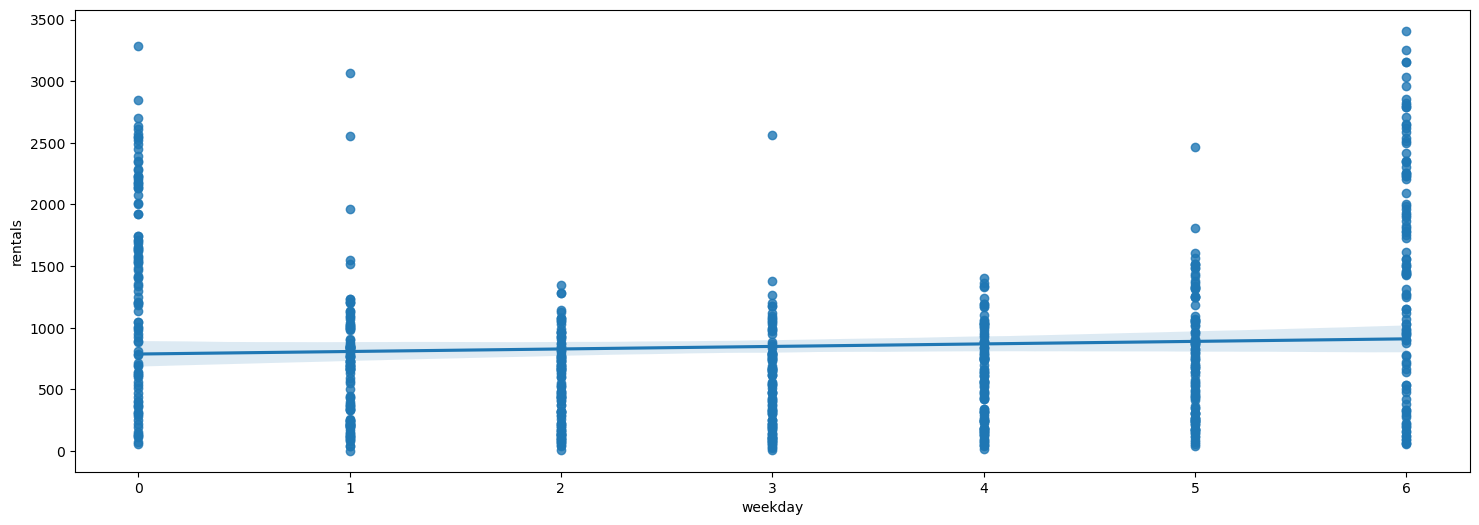

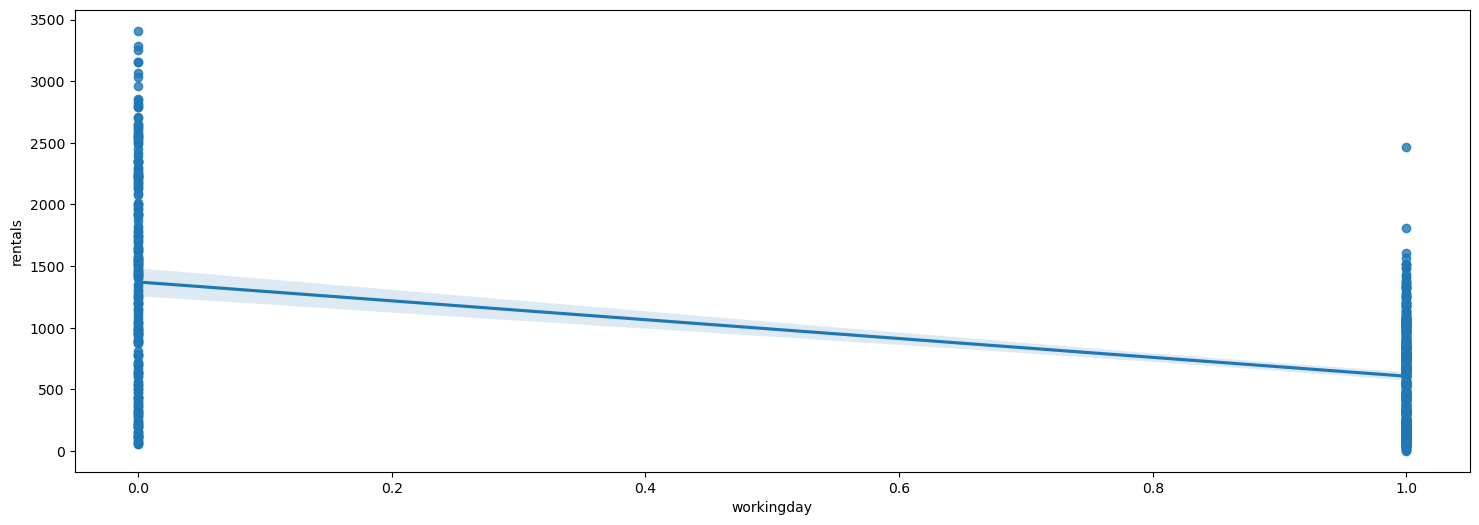

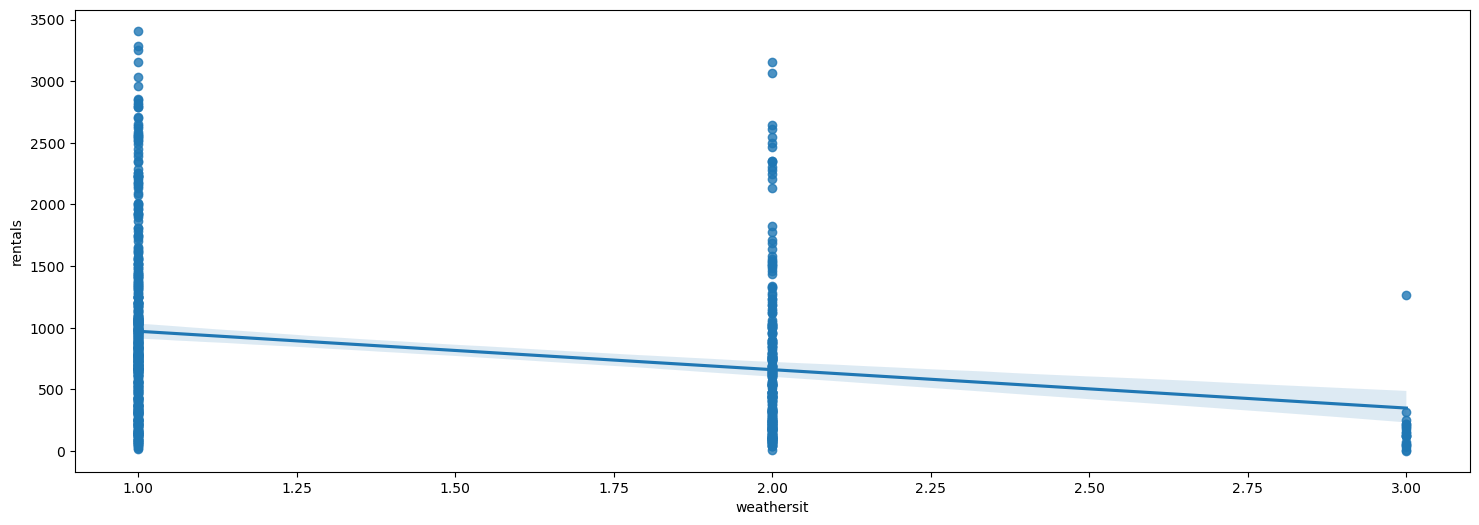

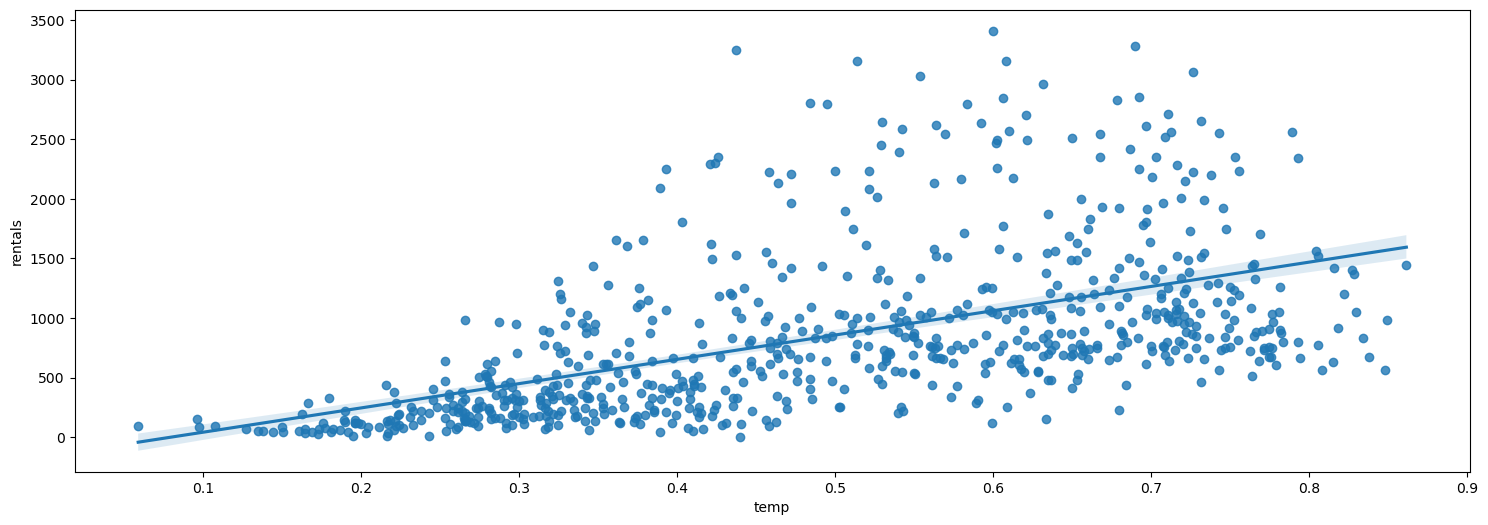

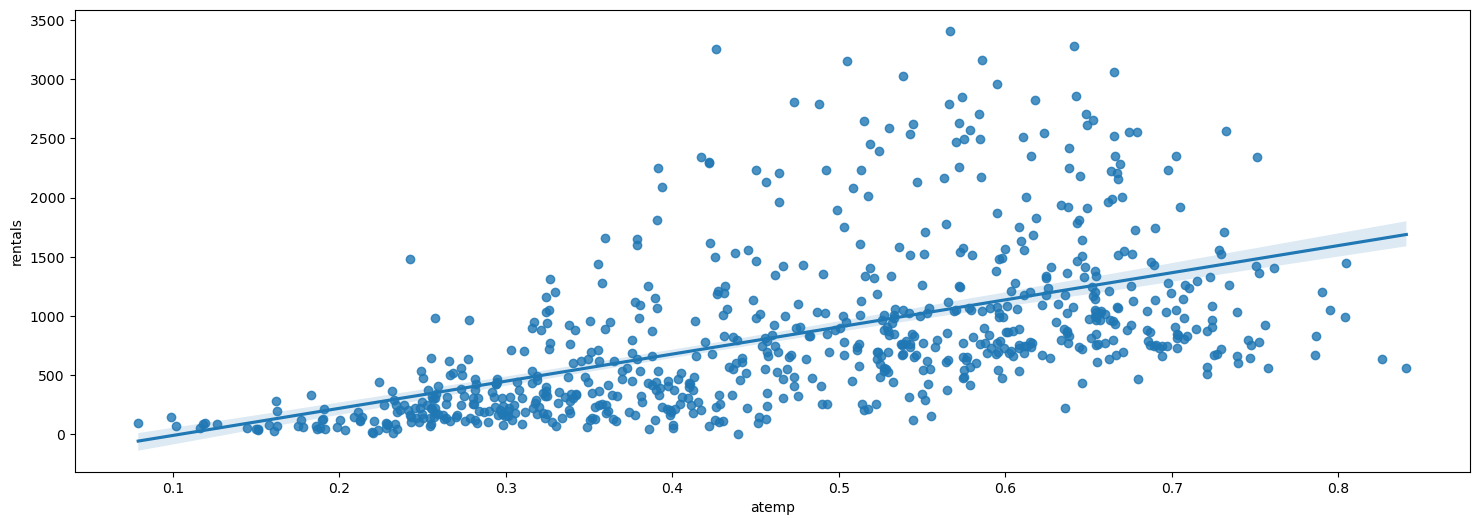

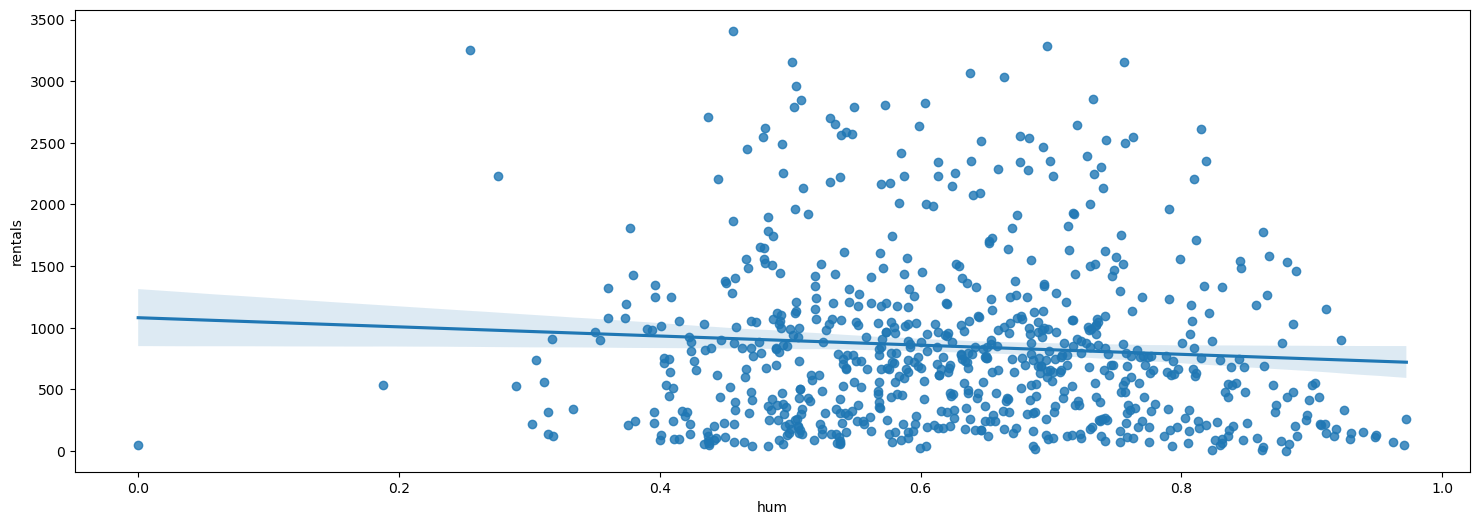

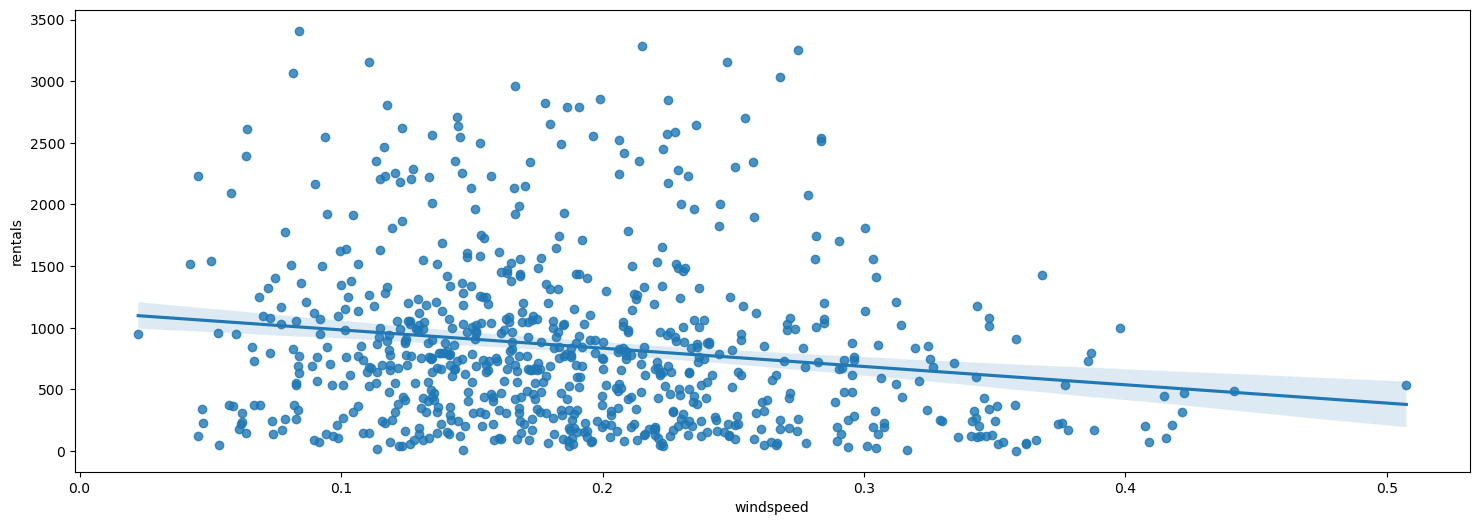

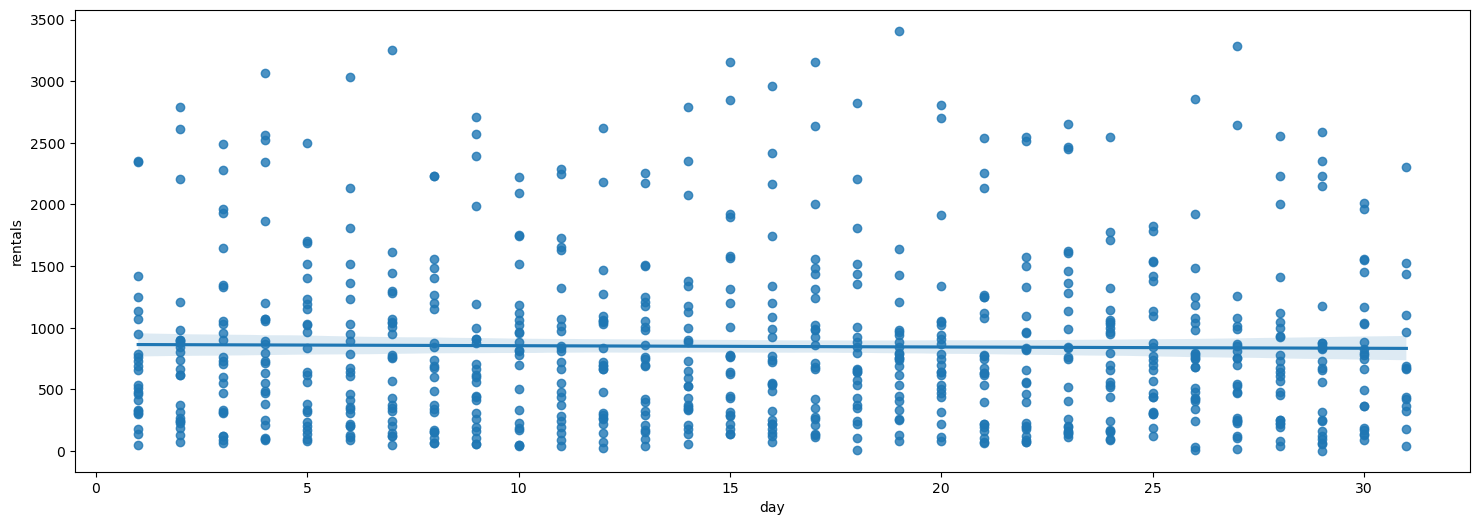

In [15]:
for col in numCols:
    plt.figure(figsize=(18,6))
    sns.regplot(x=col, y="rentals", data=df)
    plt.show()

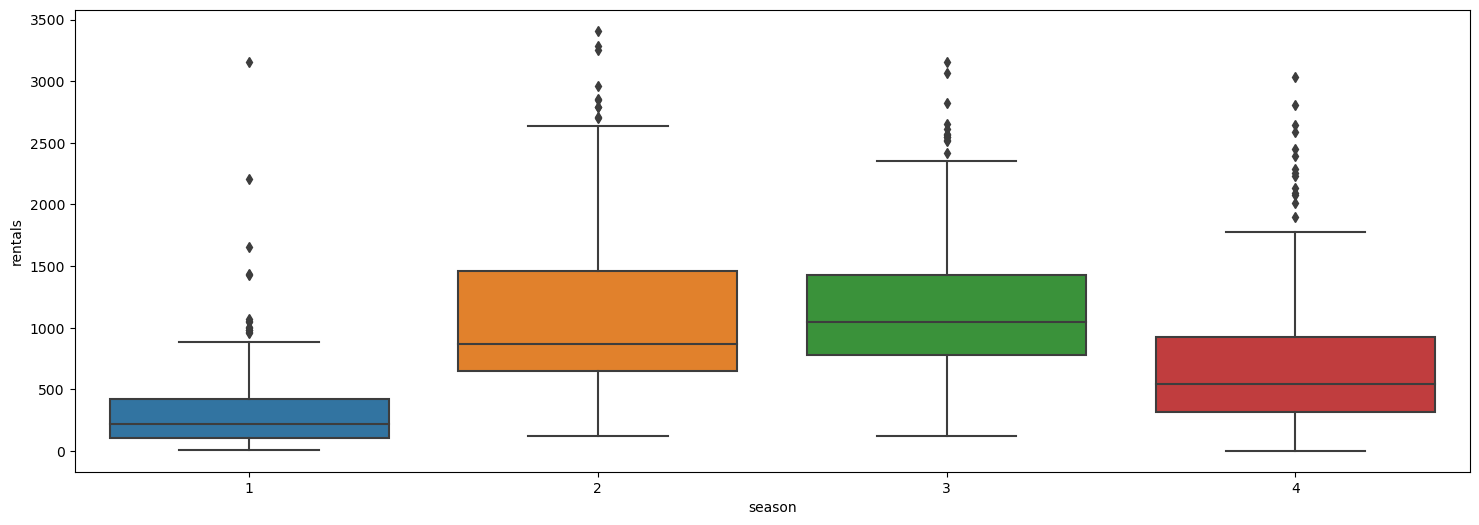

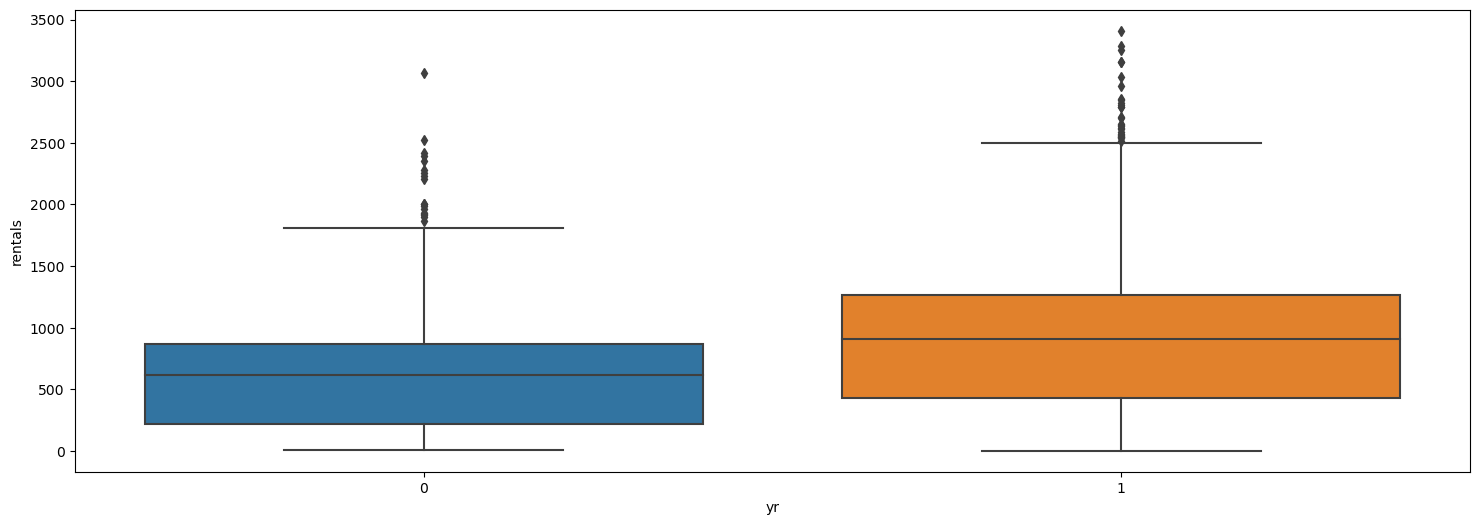

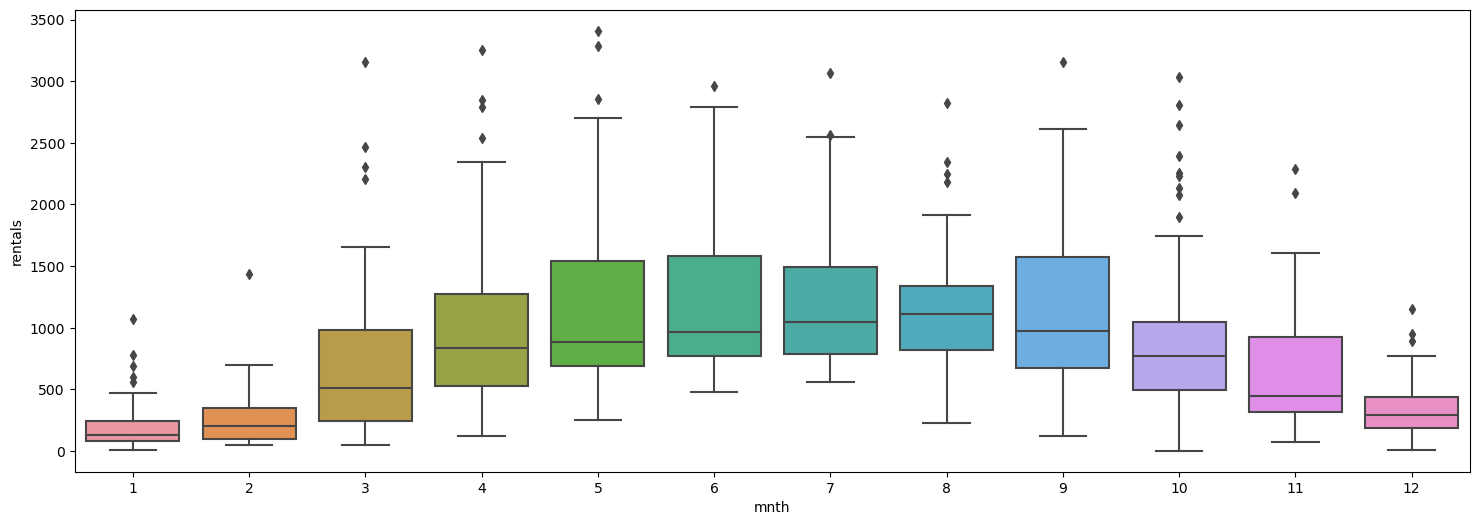

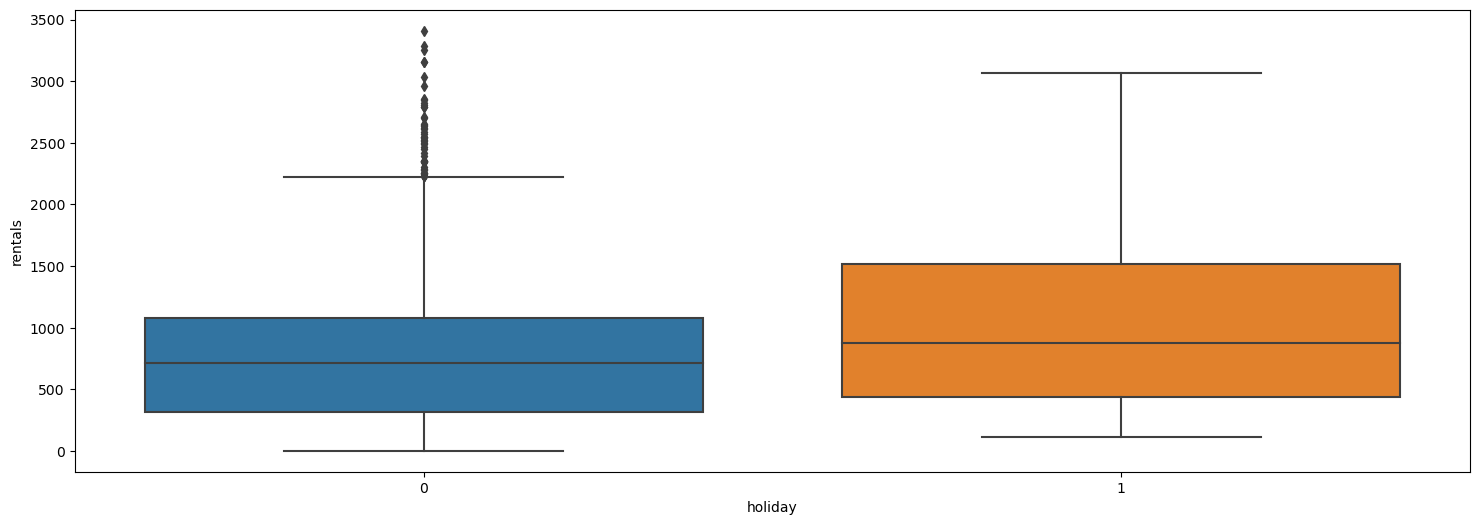

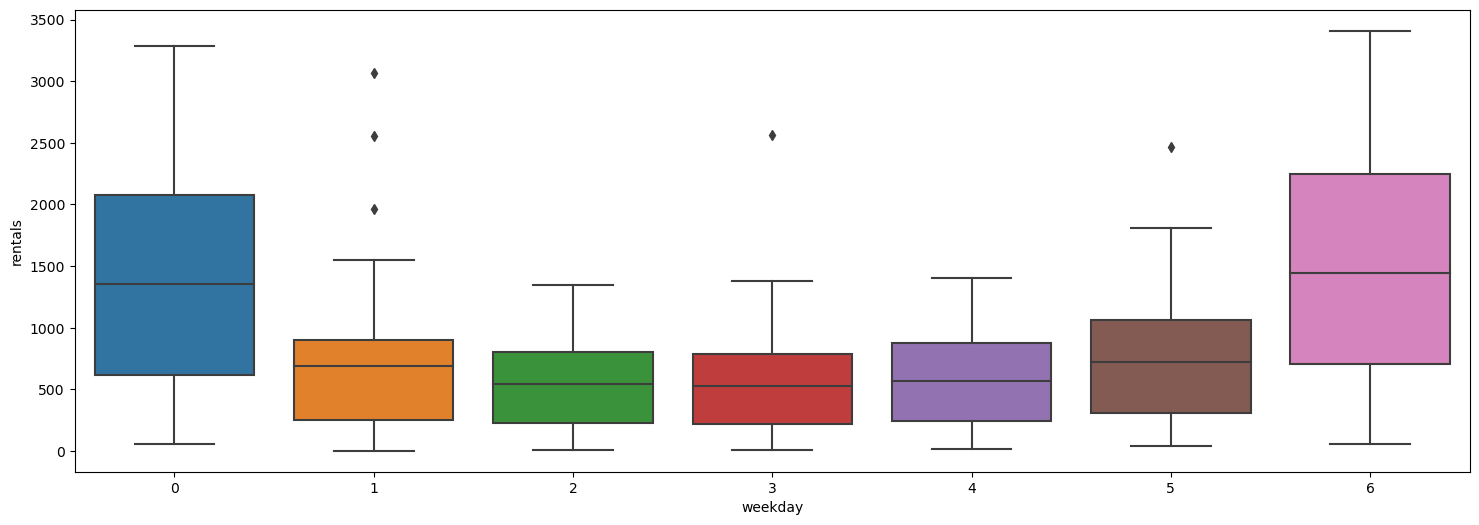

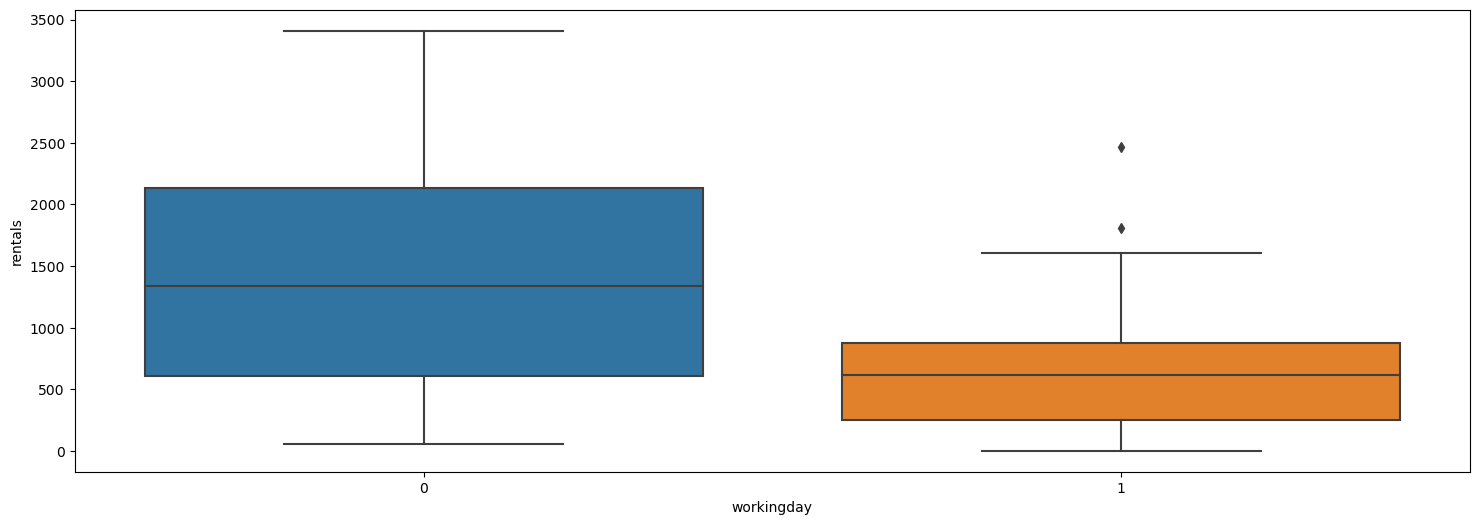

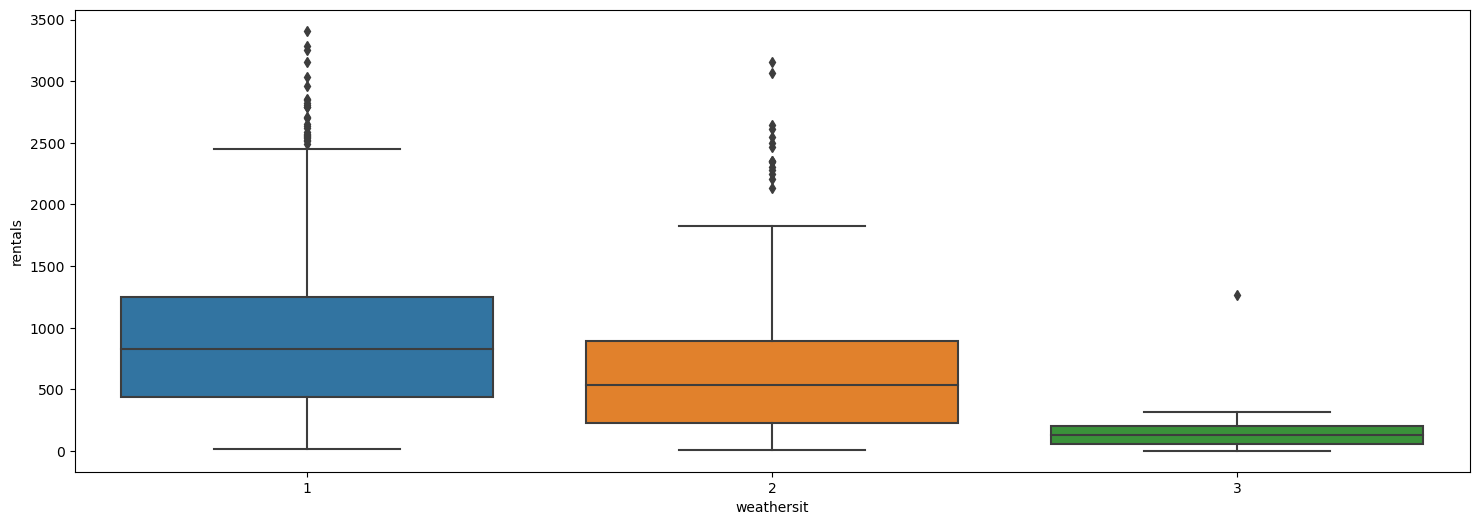

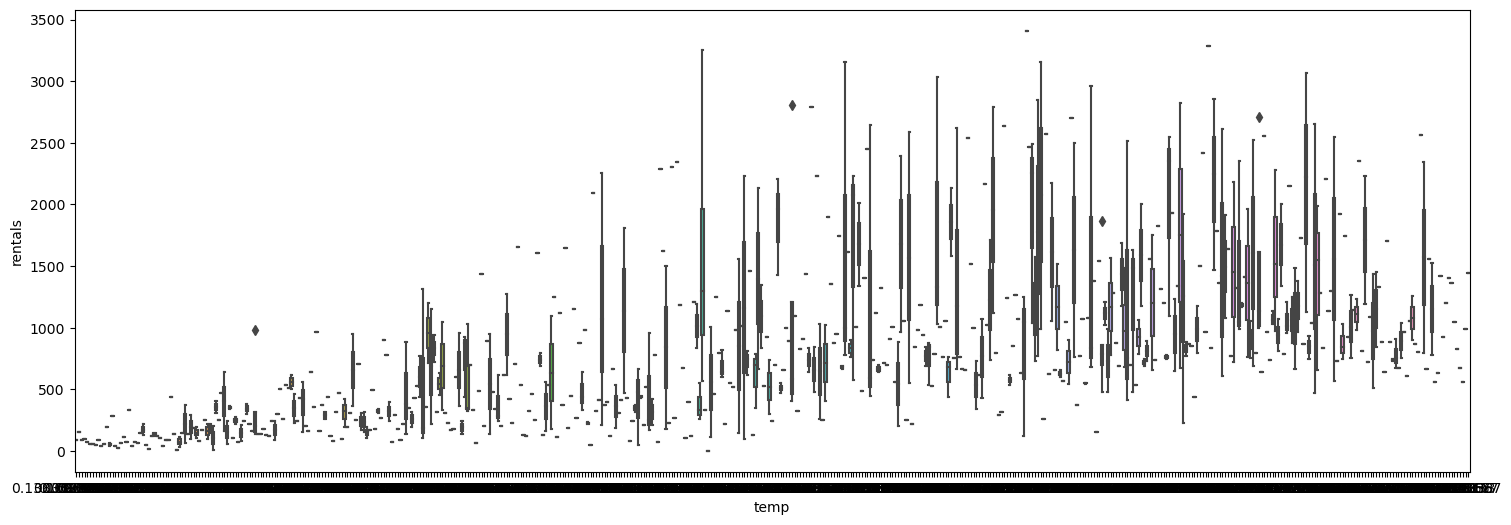

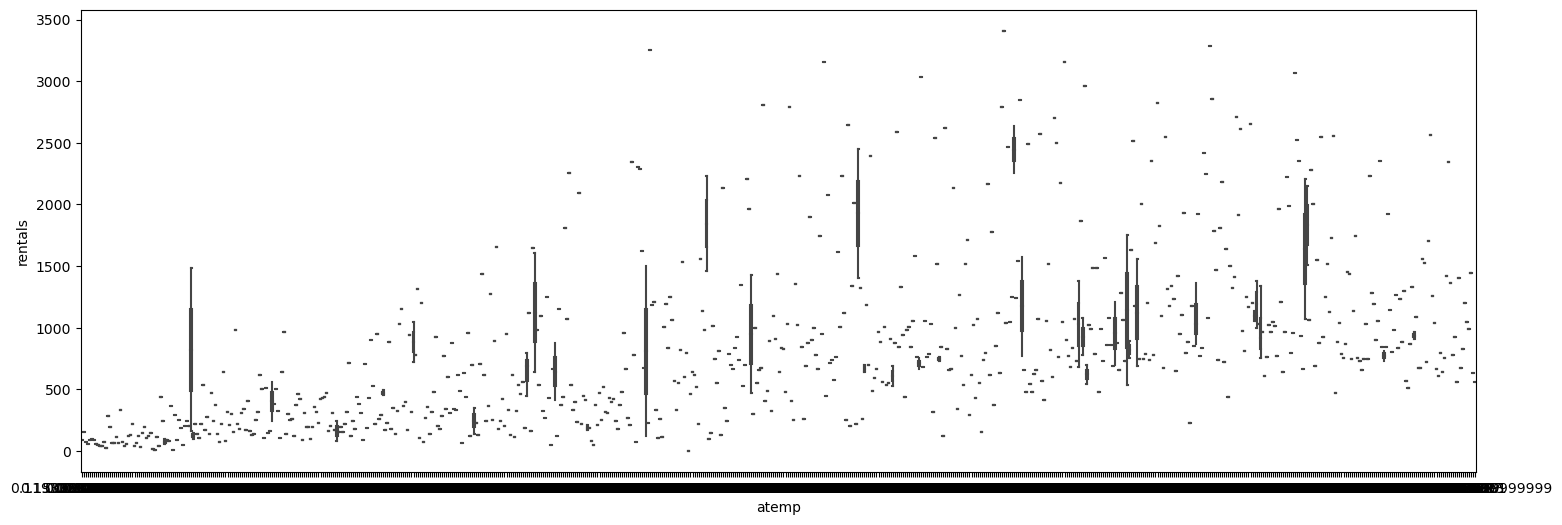

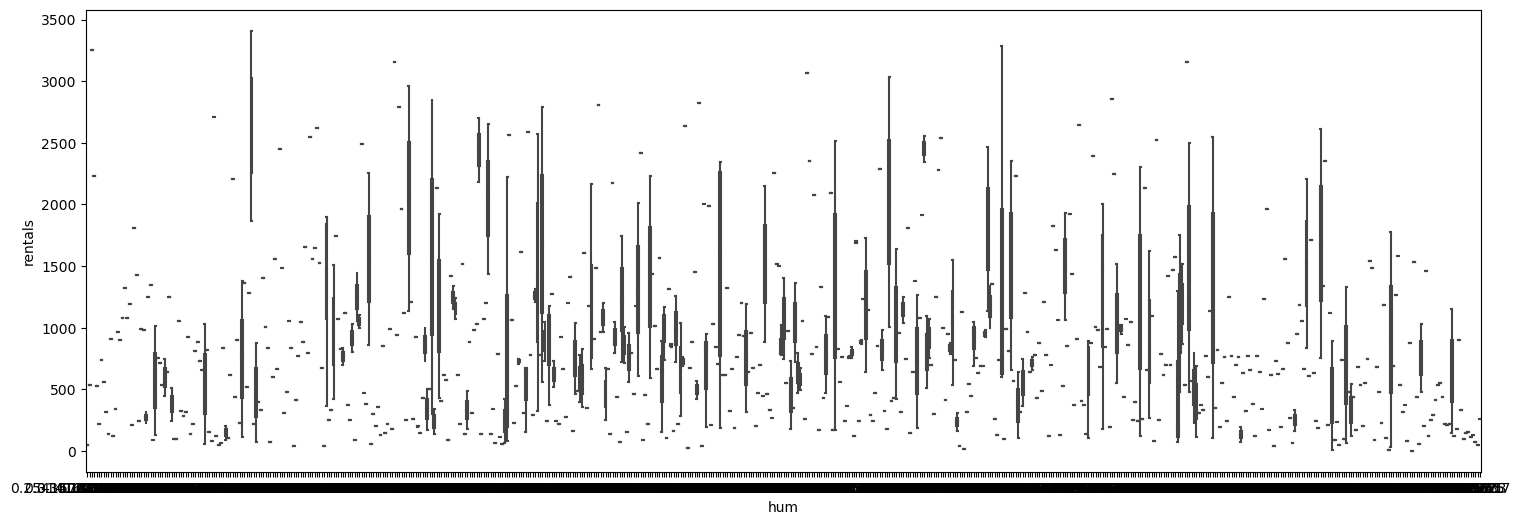

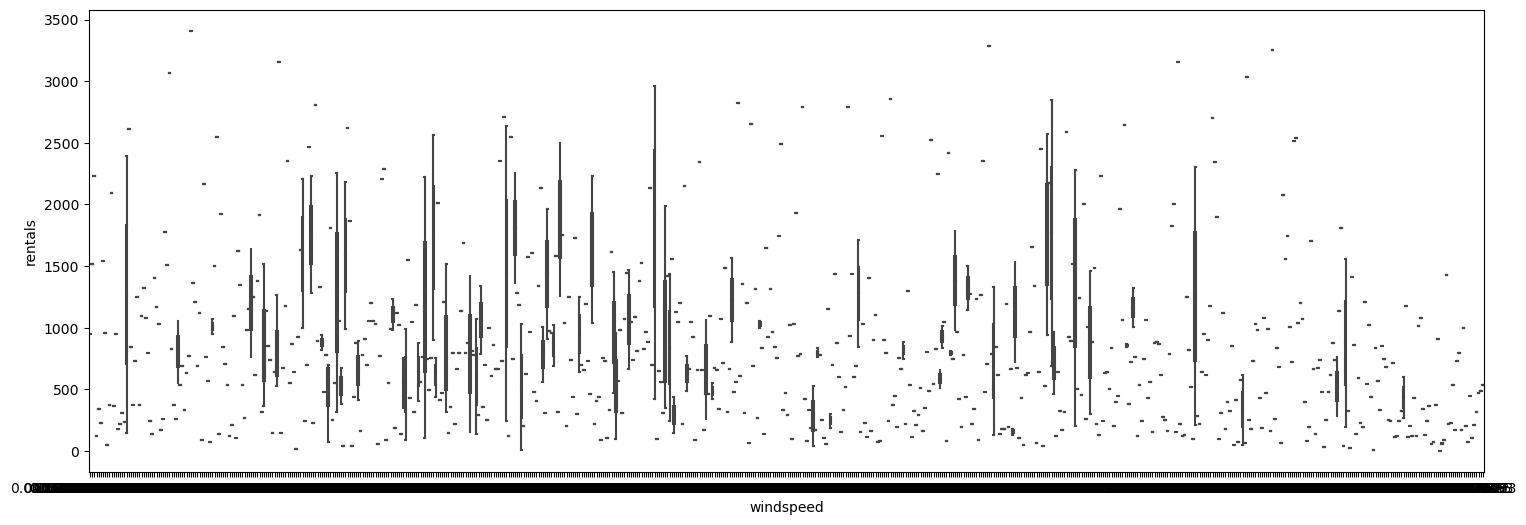

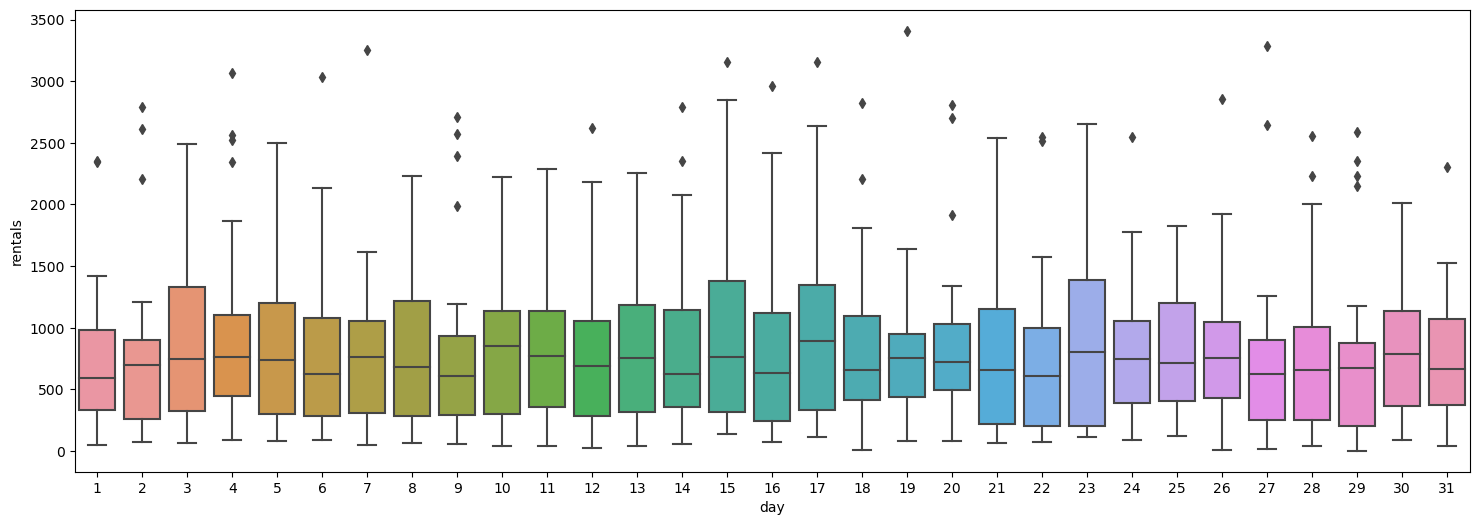

In [16]:
for col in numCols:
    plt.figure(figsize=(18,6))
    sns.boxplot(x=col, y="rentals", data=df)
    plt.show()

### Handling Outliers

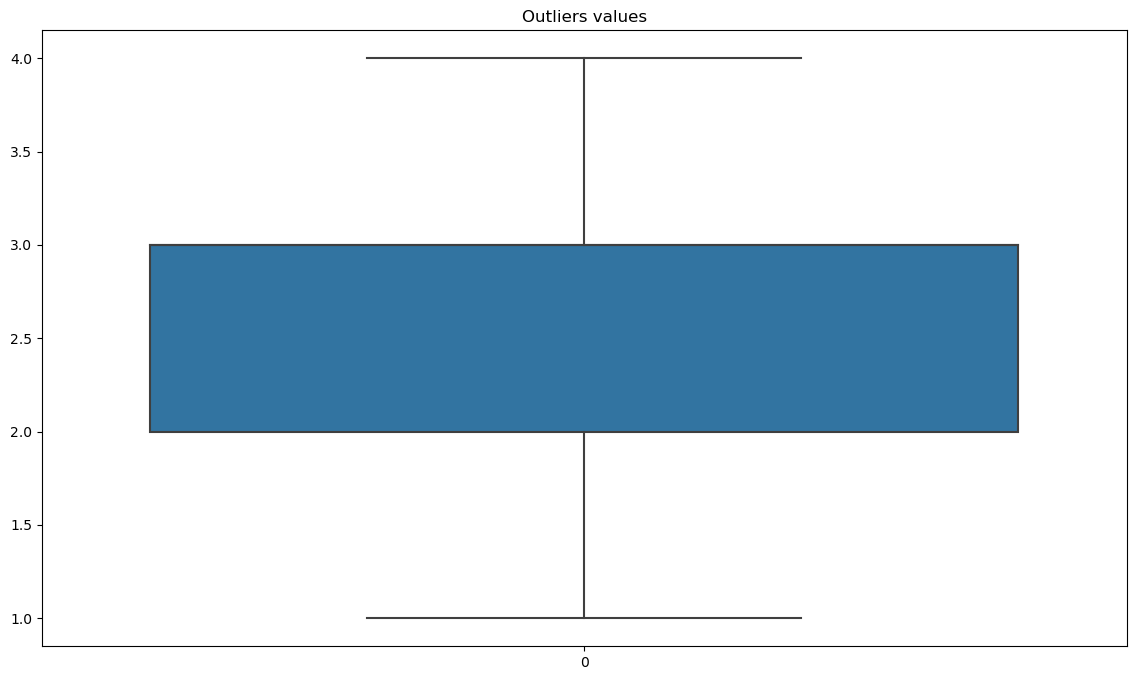

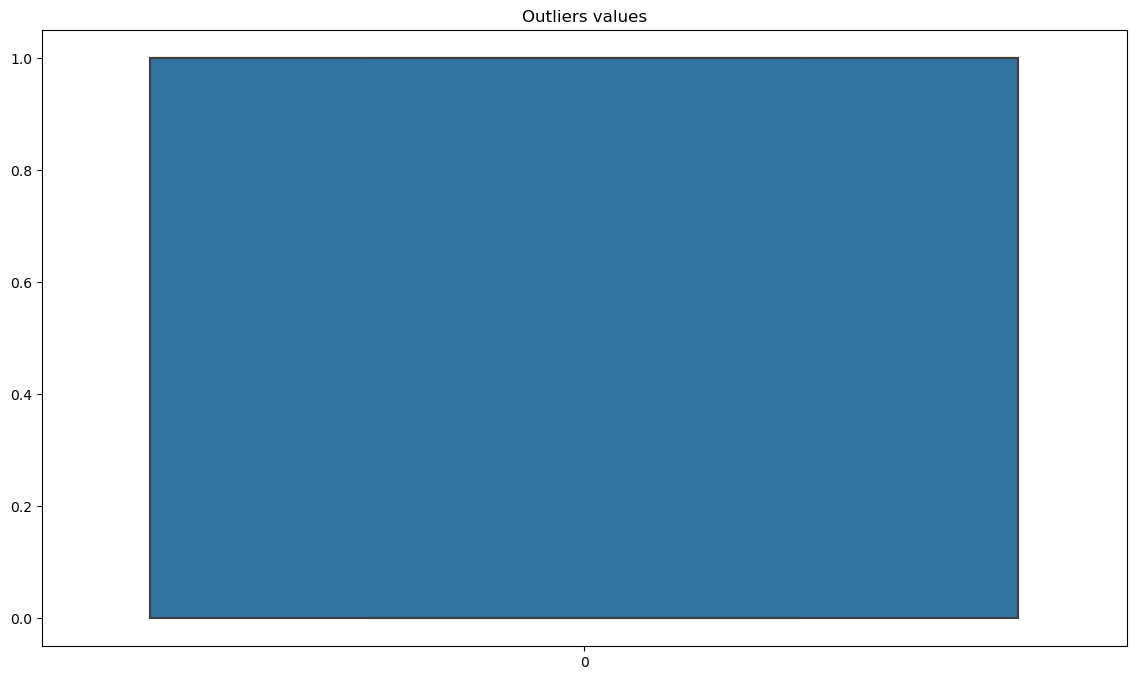

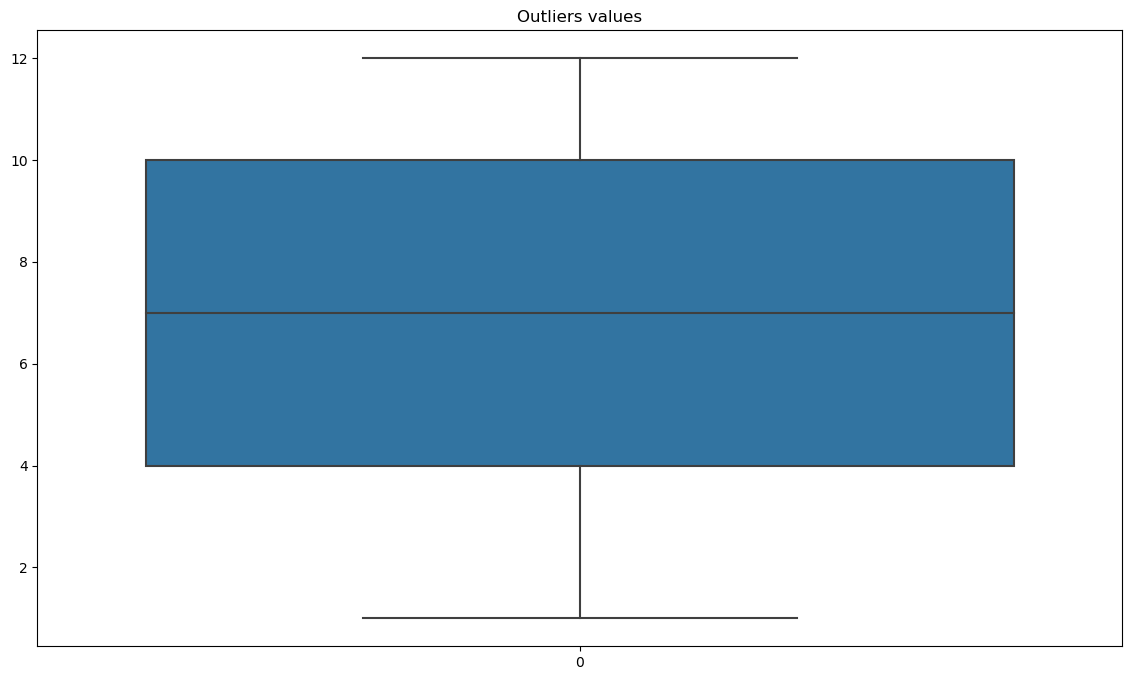

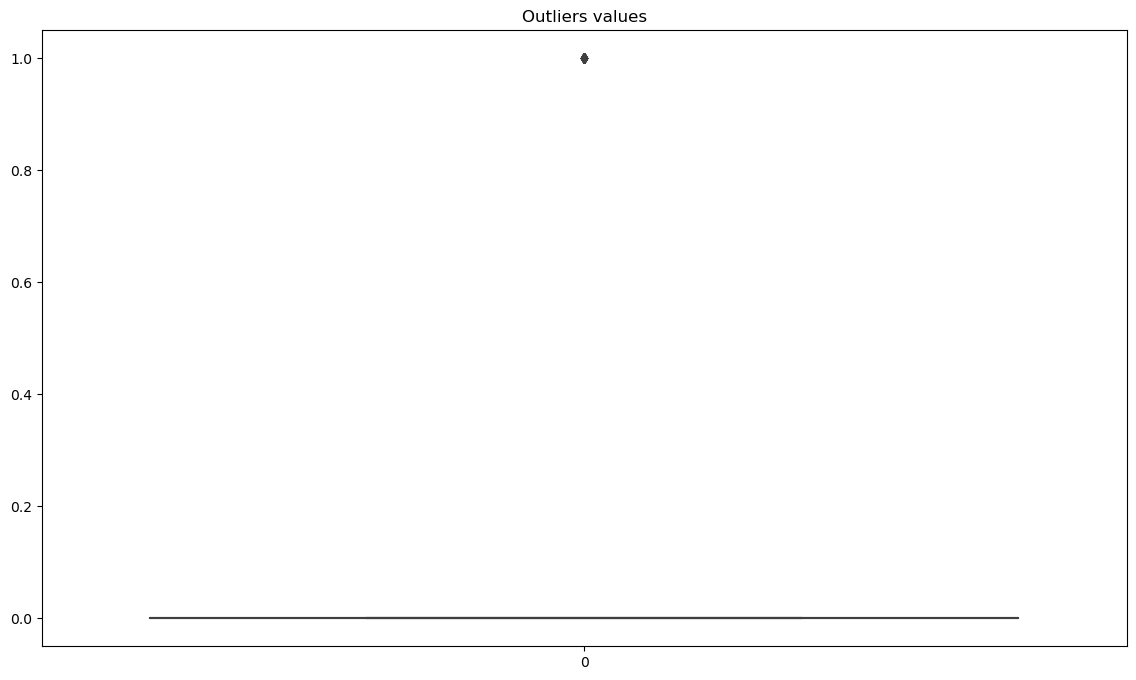

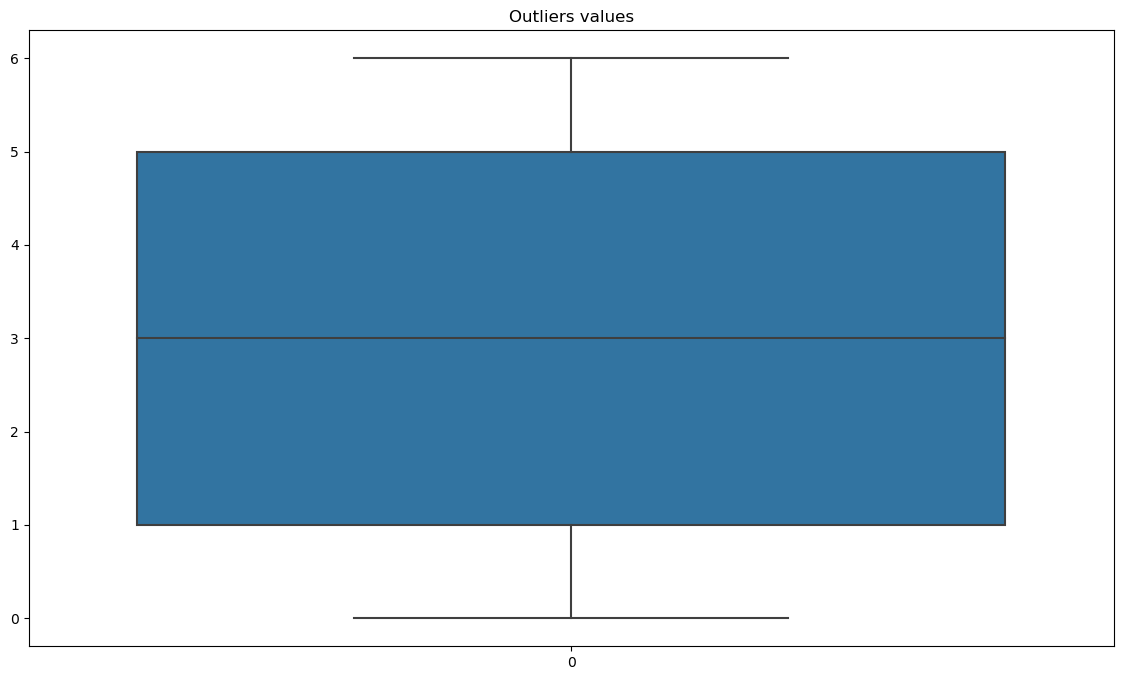

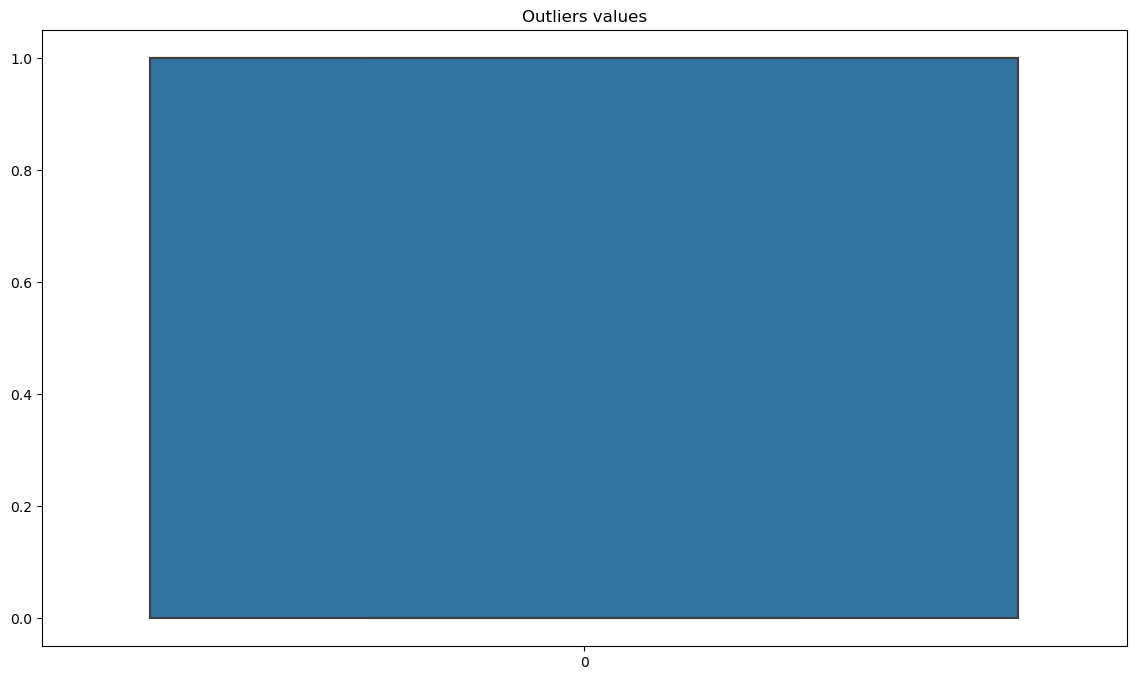

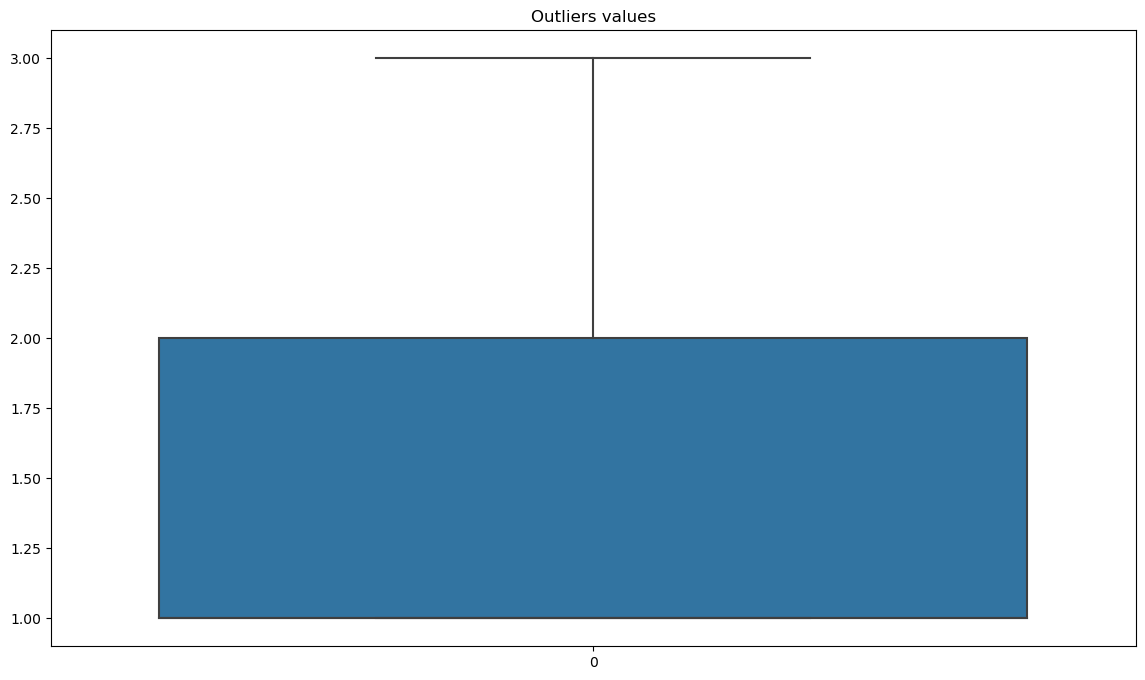

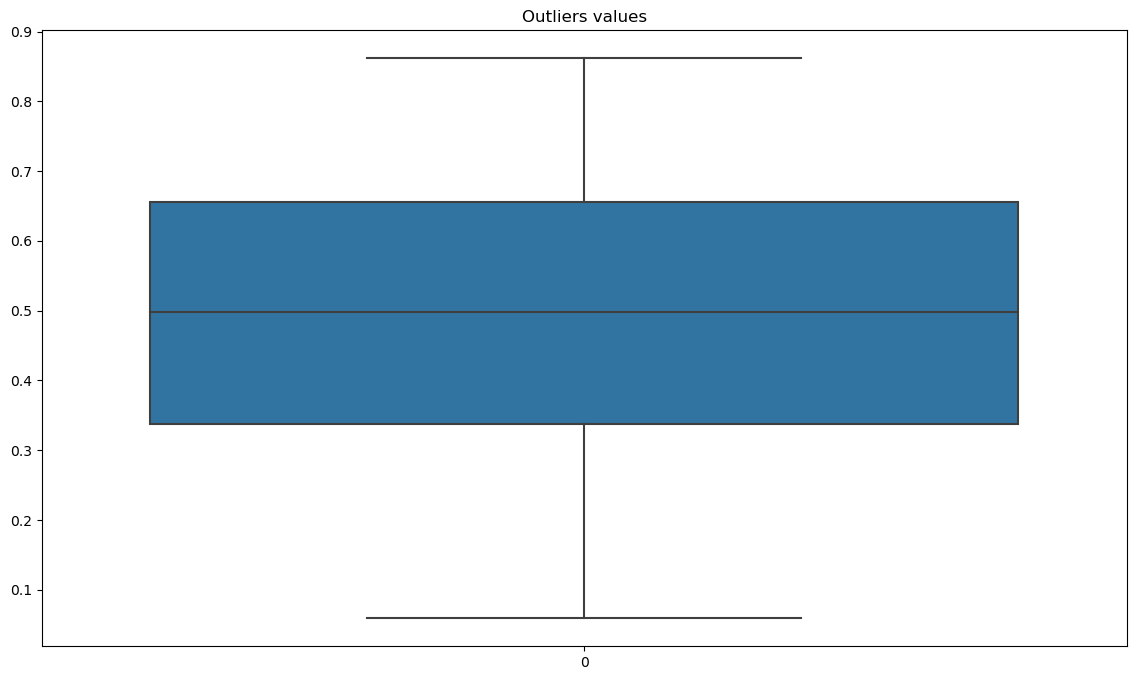

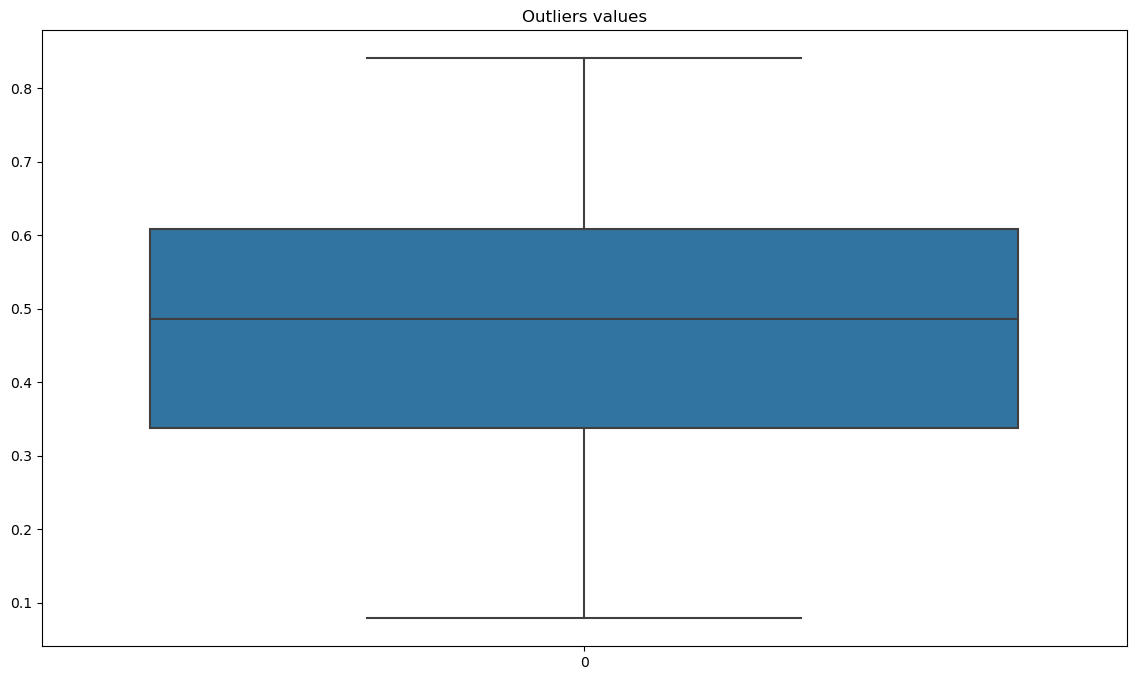

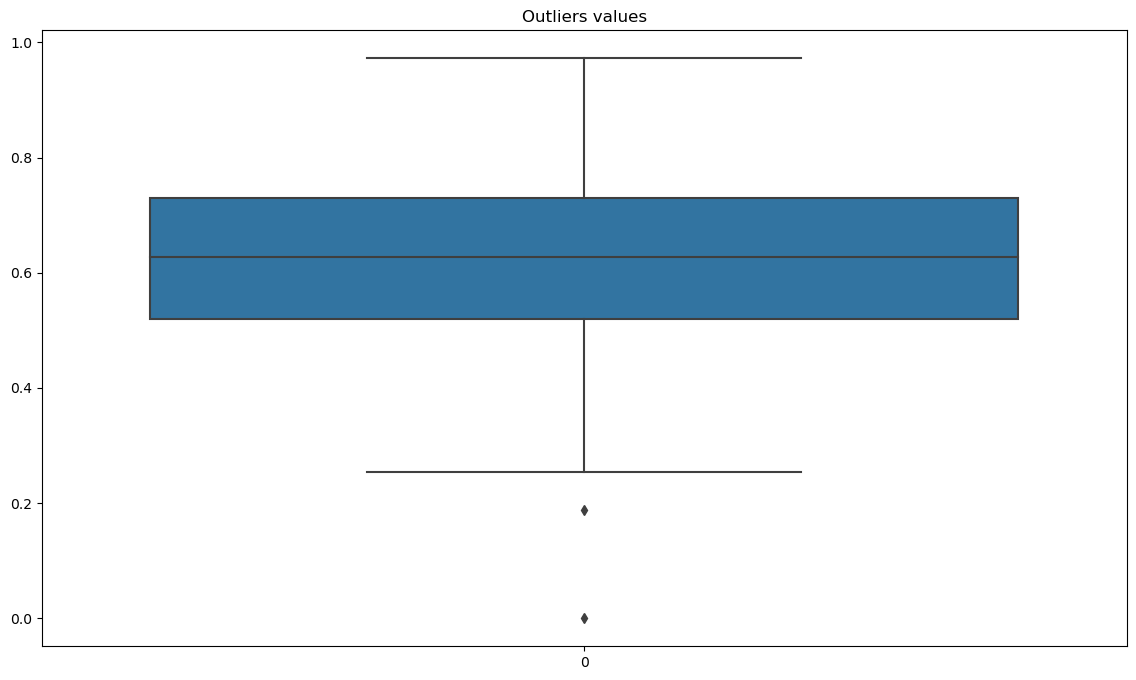

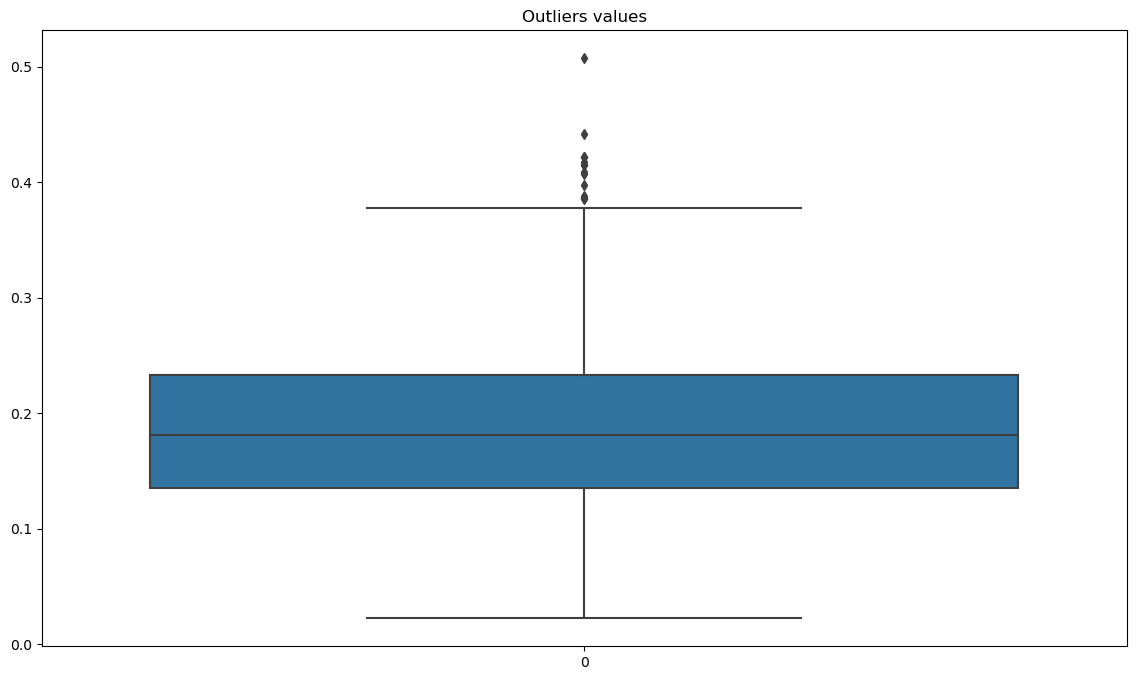

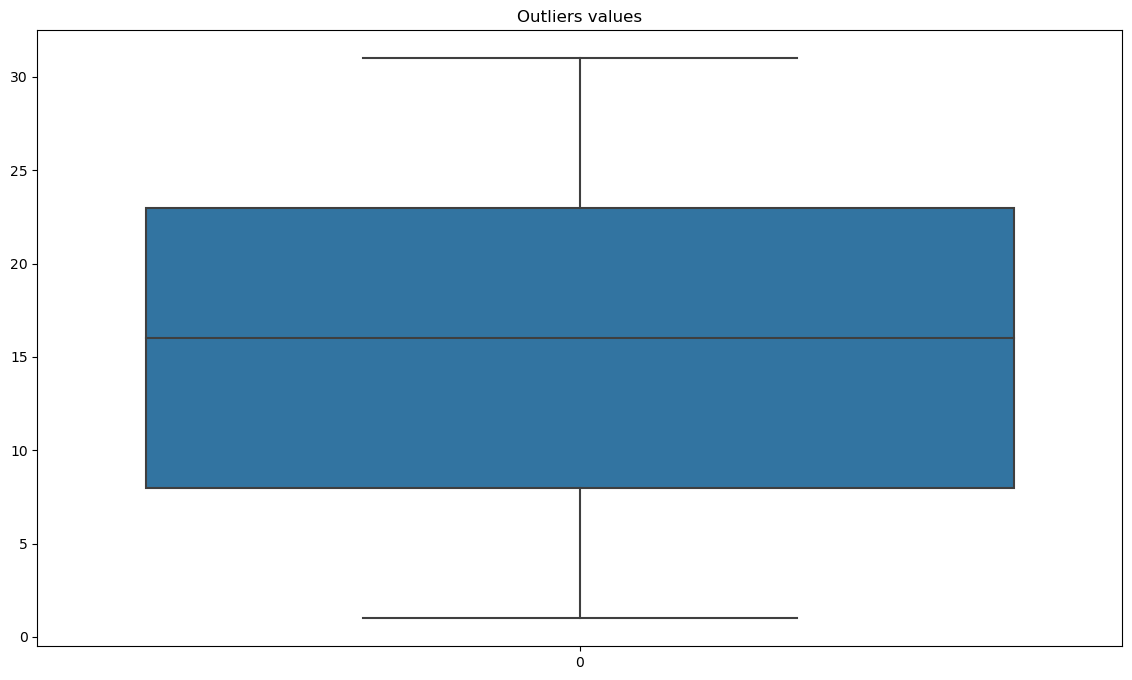

In [17]:
for col in numCols:
    plt.figure(figsize=(14,8))
    sns.boxplot(df[col], labels=[col])
    plt.title('Outliers values')
    plt.show()

Only 'hum' and 'windspeed' has outliers

In [24]:
def clean_data(data,col='column_name'):
    
    '''Takes a Dataframe column and remove outliers by replacing the outliers greater than maximum 
    with the maximum and outliers lower than the minimum with the minimum
    
    
        Parameters:
            data (2d array): Pandas Dataframe column
    
            col (str) : The Dataframe Column name
    
        Returns:
            Cleaned column: Description of return value
    
    '''
    
    import numpy as np
    import pandas as pd
    import seaborn as sns
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)

    iqr = q3 - q1

    min = q1 - 1.5*(iqr)
    max = q3 + 1.5*(iqr)
    
    for i in data.index:
        if data.loc[i, col] > max:
            data.loc[i, col] = max
        if data.loc[i, col] < min:
            data.loc[i, col] = min
    plt.figure(figsize=(20, 15))        
    sns.boxplot(data[col],orient='v')
    plt.title(f'Cleaned {col} column')
    plt.show()

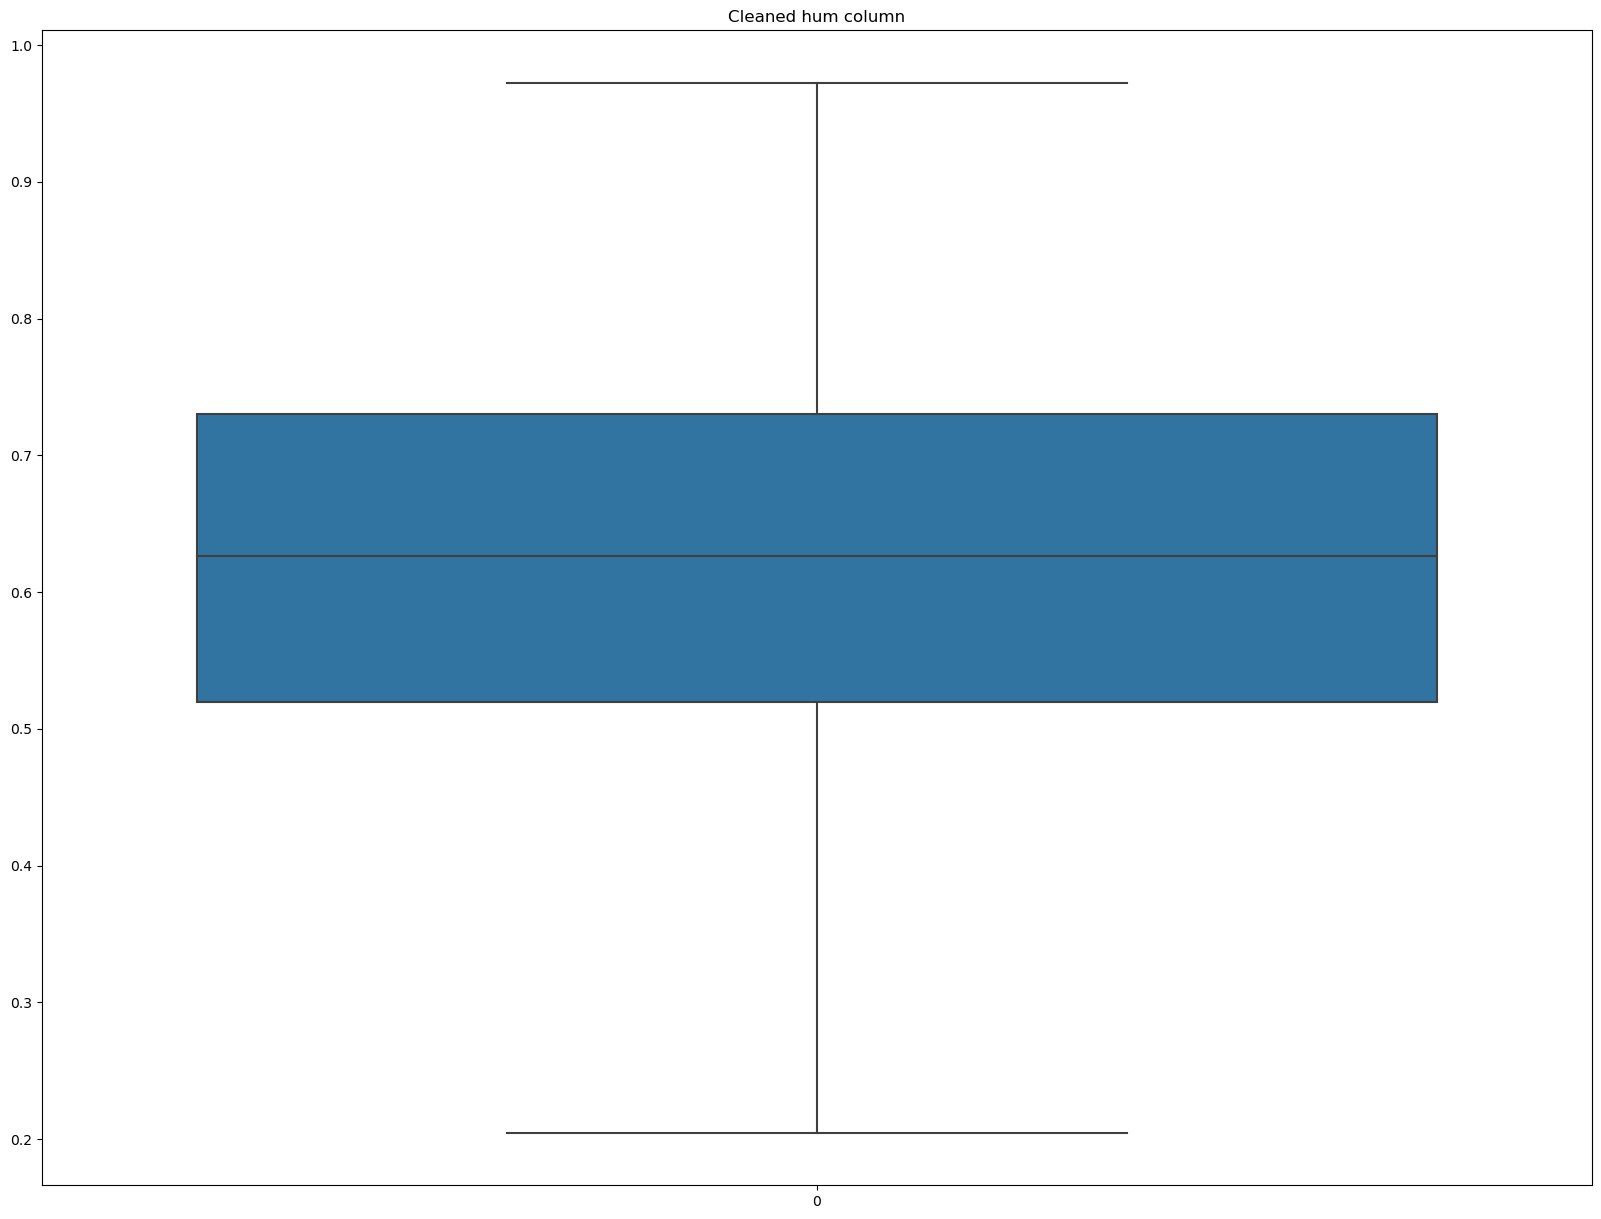

In [25]:
clean_data(df, 'hum')

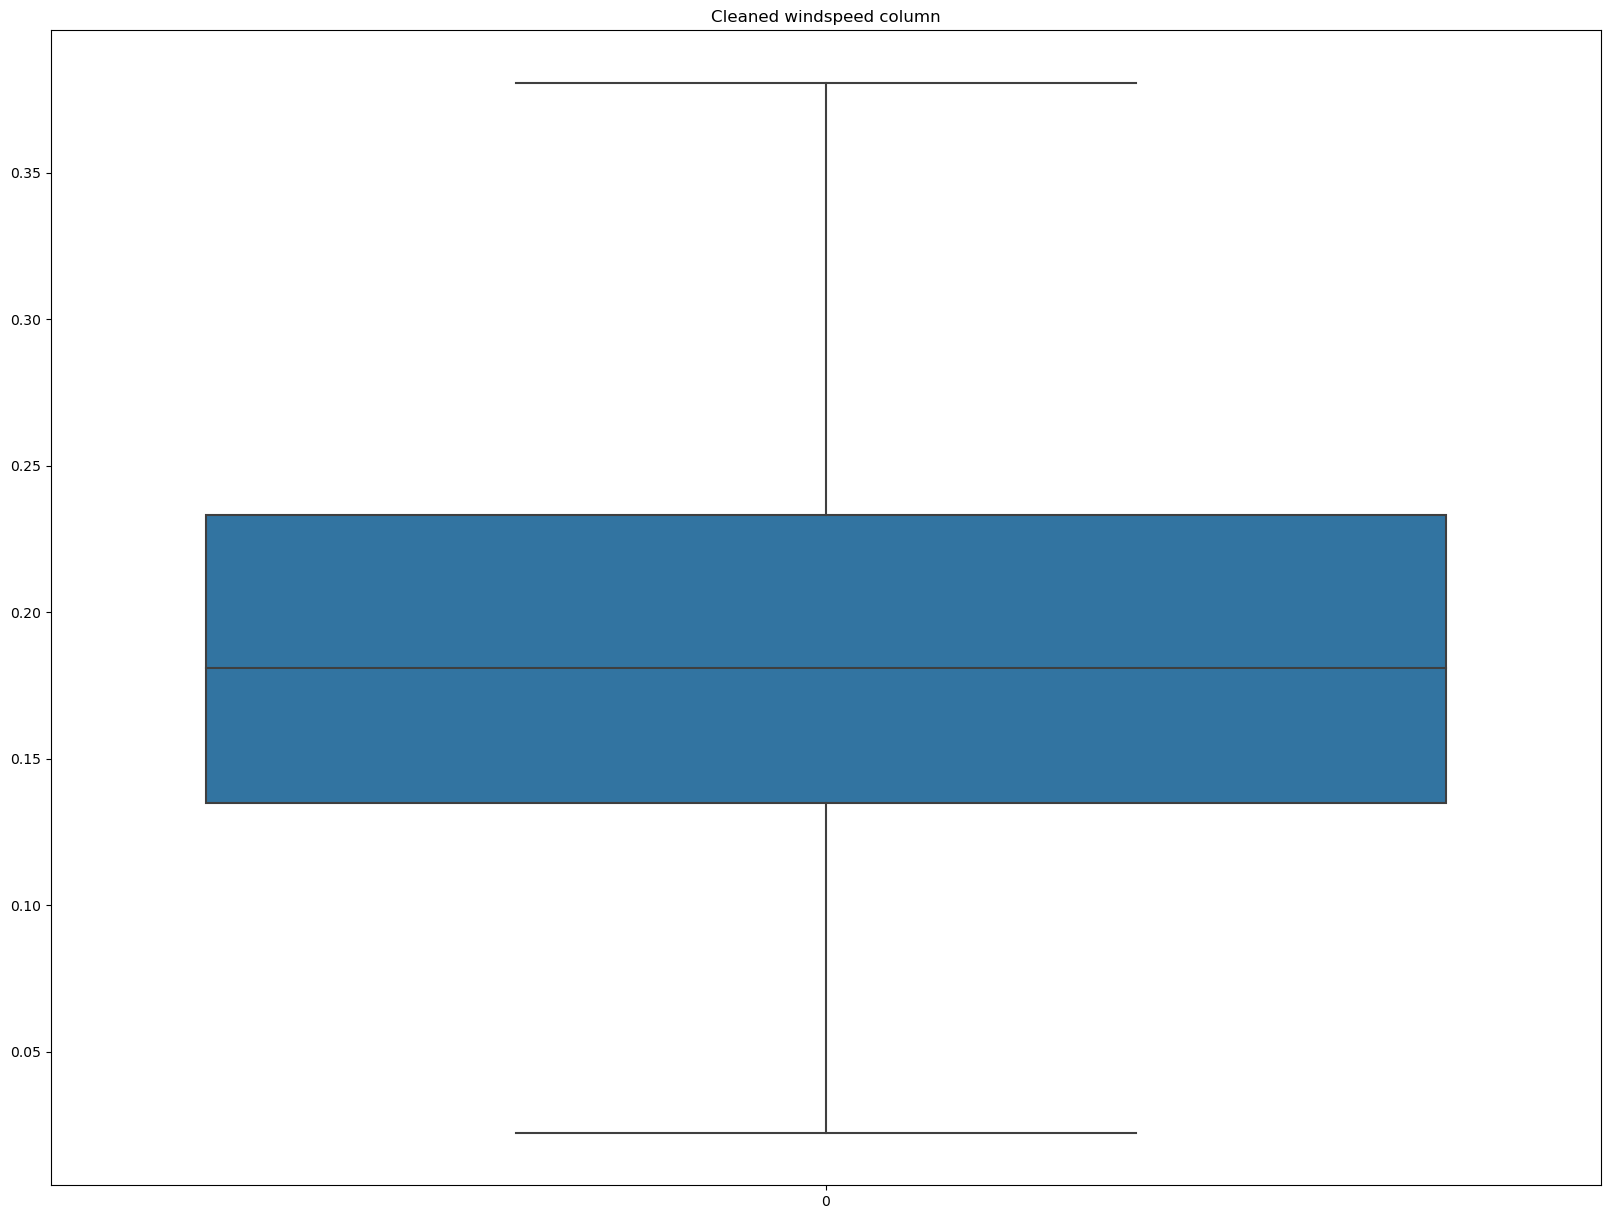

In [26]:
clean_data(df, 'windspeed')

## Exploring the cleaned data

In [27]:
df.head(10)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals,day
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,1
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,2
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,3
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,4
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,5
5,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,88,6
6,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.168726,148,7
7,1,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.266804,68,8
8,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,54,9
9,1,0,1,0,1,1,1,0.150833,0.150888,0.482917,0.223267,41,10


### Correlation

<AxesSubplot:>

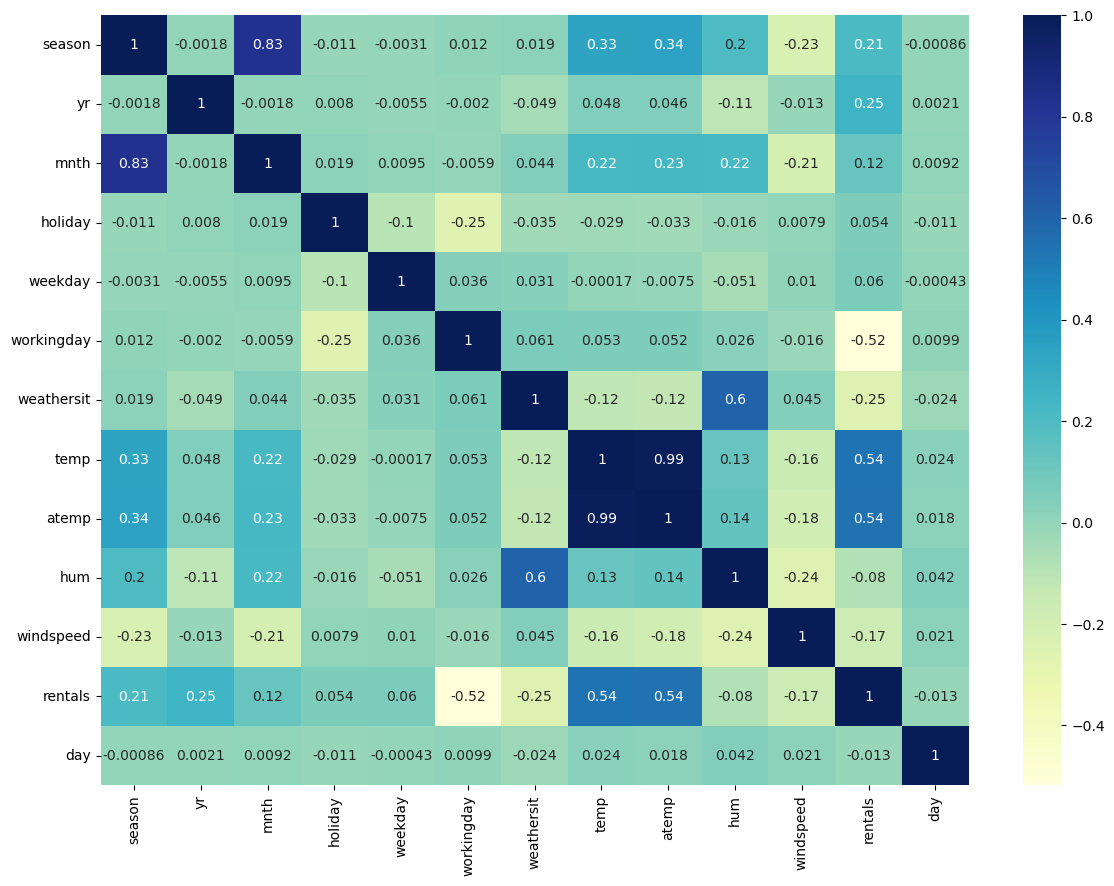

In [28]:
plt.figure(figsize = (14,10))
sns.heatmap(df.corr() , annot = True , cmap = "YlGnBu")

### Feature Selection
less than 5% not accepted as a feature

In [29]:
round(abs(df.corr()['rentals']*100).sort_values(ascending=False), 2)

rentals       100.00
atemp          54.39
temp           54.33
workingday     51.80
yr             24.85
weathersit     24.74
season         21.04
windspeed      16.63
mnth           12.30
hum             8.00
weekday         5.99
holiday         5.43
day             1.34
Name: rentals, dtype: float64

<AxesSubplot:>

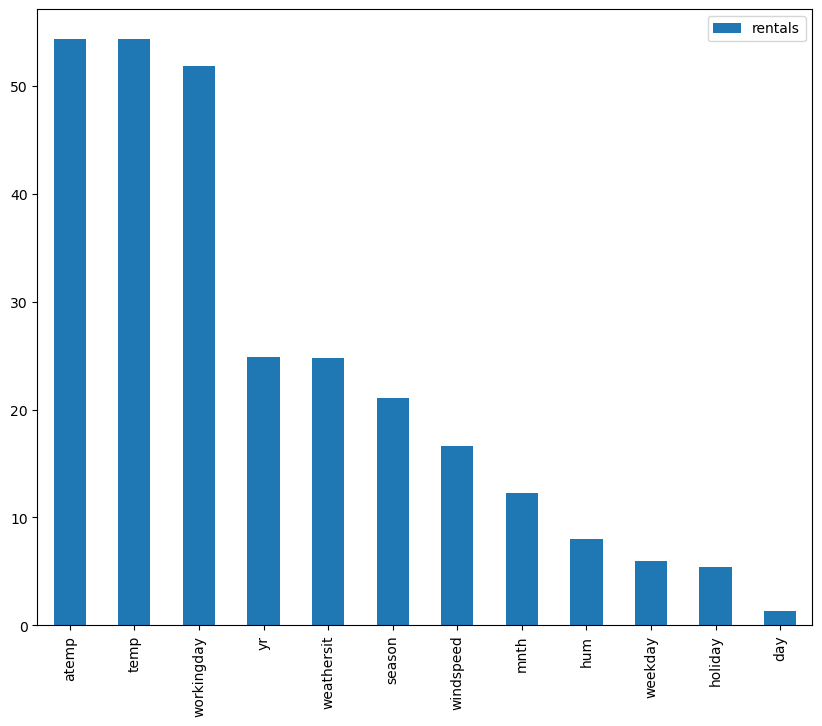

In [30]:
pd.DataFrame(abs(df.corr()['rentals'].drop('rentals')*100).sort_values(ascending=False)).plot.bar(figsize = (10,8))

## MODELING

### Feature set
Let's define feature sets, X:

In [31]:
X = df[['season', 'yr','mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp','atemp', 'hum', 'windspeed','day']]
columns = ['season', 'yr','mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp','atemp', 'hum', 'windspeed','day']
X[0:5]

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,day
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,1
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,2
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,3
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,4
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,5


What are our labels?

In [32]:
y = df['rentals']
y[0:5]

0    331
1    131
2    120
3    108
4     82
Name: rentals, dtype: int64

In [33]:
# Standard scaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X =pd.DataFrame(X,columns=columns)
X.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,day
0,-1.348213,-1.001369,-1.600161,-0.171981,1.498809,-1.471225,1.110427,-0.826662,-0.679946,1.257836,-0.388927,-1.674108
1,-1.348213,-1.001369,-1.600161,-0.171981,-1.496077,-1.471225,1.110427,-0.721095,-0.740652,0.480727,0.776447,-1.560522
2,-1.348213,-1.001369,-1.600161,-0.171981,-0.996930,0.679706,-0.726048,-1.634657,-1.749767,-1.351928,0.773404,-1.446936
3,-1.348213,-1.001369,-1.600161,-0.171981,-0.497782,0.679706,-0.726048,-1.614780,-1.610270,-0.267392,-0.390911,-1.333351
4,-1.348213,-1.001369,-1.600161,-0.171981,0.001366,0.679706,-0.726048,-1.467414,-1.504971,-1.354165,-0.038969,-1.219765


### Train Test Split

In [34]:
x_train, x_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (511, 12) (511,)
Test set: (220, 12) (220,)


## Lets Do Multiple Line Regression 

In [35]:
lre=LinearRegression()

In [36]:
lre.fit(x_train, y_train)

LinearRegression()

In [37]:
yhat_train = lre.predict(x_train)
yhat_train[:5]

array([1135.23554512, -200.94591883, 1839.96248488, 1164.07043276,
        933.88015737])

In [38]:
yhat_test = lre.predict(x_test)
yhat_test[:5]

array([1774.72273283, 1087.20406843,  848.66987814,  -94.84226146,
        413.24916072])

In [39]:
# Libraries for plotting
from ipywidgets import interact, interactive, fixed, interact_manual

def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Rentals')
    plt.ylabel('Proportion')
    plt.legend()

    plt.show()
    plt.close()

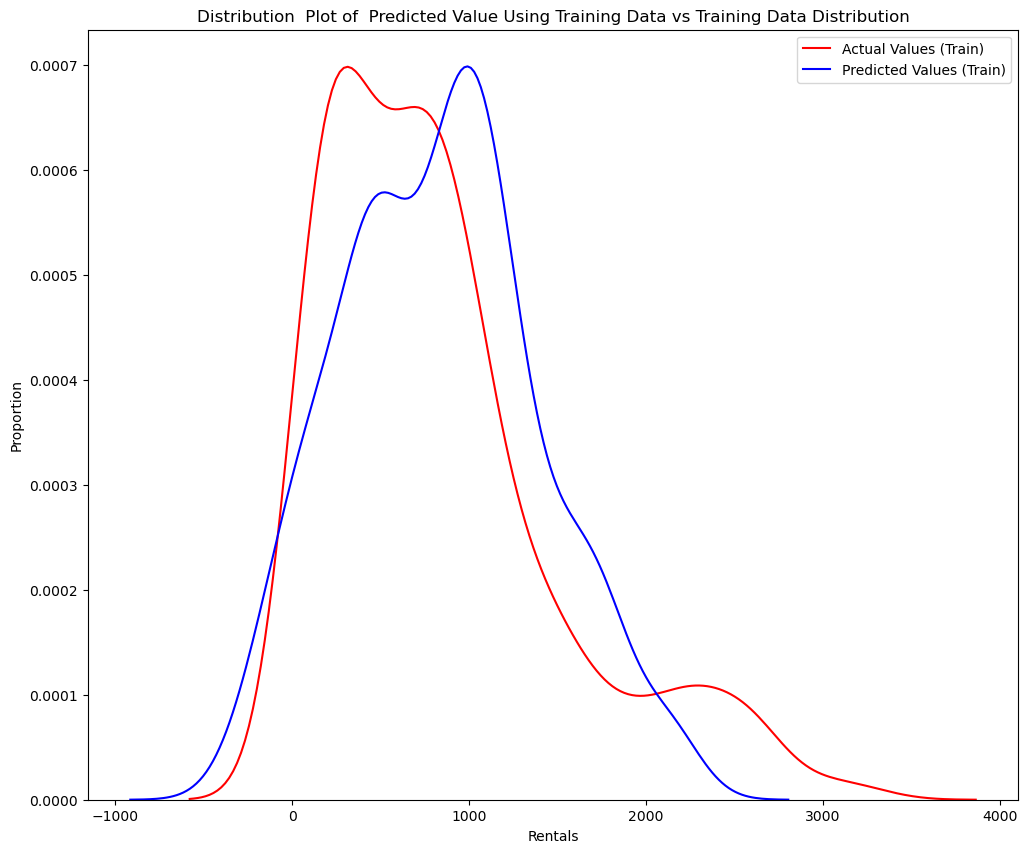

In [40]:
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.

So far, the model seems to be doing well in learning from the training dataset. But what happens when the model encounters new data from the testing dataset? When the model generates new values from the test data, we see the distribution of the predicted values is much different from the actual target values

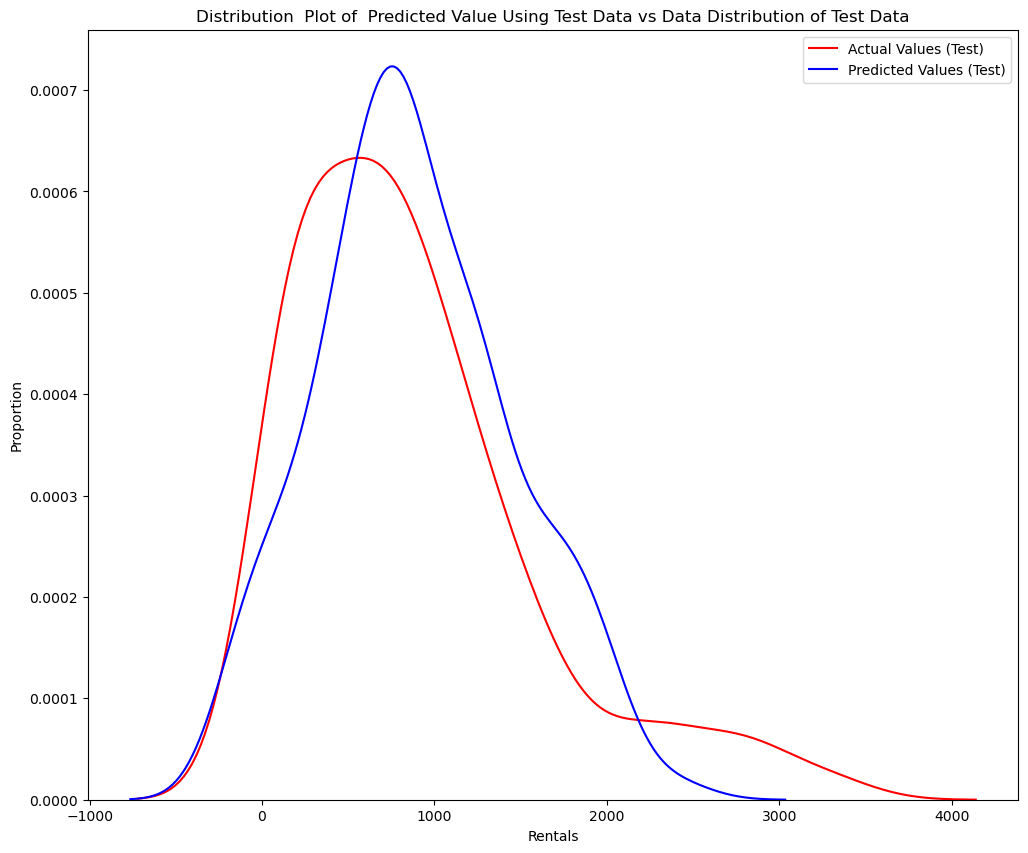

In [41]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Test)",Title)

Figure 2: Plot of predicted value using the test data compared to the actual values of the test data.

* Comparing Figure 1 and Figure 2, they are variances

In [42]:
mean_squared_error(y_train,yhat_train)

140446.25160898743

In [43]:
mean_squared_error(y_test,yhat_test)

170303.77640849006

In [44]:
lre.score(x_train,y_train)

0.6902260516815917

In [45]:
lre.score(x_test,y_test)

0.6661301352365232

### Lets do MLR without a Training and Test Sets

In [46]:
# Create the linear regression object
lm = LinearRegression()

In [47]:
lm.fit(X,y)

LinearRegression()

In [48]:
Yhat = lm.predict(X)
Yhat[0:5]

array([ 976.84773988,  801.19965033, -134.51917068,  -70.5945491 ,
         39.08955809])

In [49]:
lm.intercept_

848.1764705882352

In [50]:
lm.coef_

array([  68.67763959,  143.30458688,  -53.82600861,  -45.77286931,
         52.59962177, -384.63939408,  -61.89431892,  219.42889179,
        145.40324777,  -54.5578394 ,  -63.11914999,  -11.40854434])

Text(0.5, 1.0, 'Actual vs Fitted Values for Rentals')

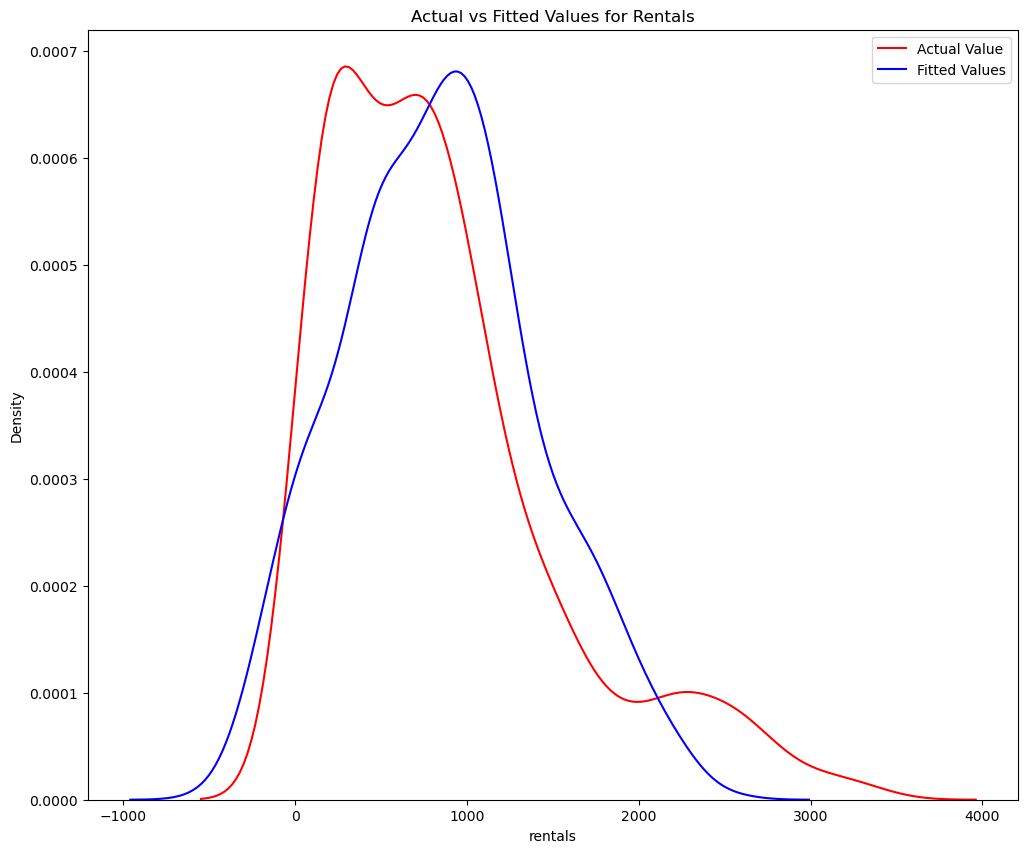

In [51]:
plt.figure(figsize=(12, 10))


ax1 = sns.distplot(y, hist=False, color="r", label="Actual Value")
sns.distplot(Yhat, hist=False, color="b", label="Fitted Values", ax=ax1)
plt.legend()
plt.title('Actual vs Fitted Values for Rentals')

In [52]:
mean_squared_error(y,Yhat)

146948.45849553682

In [53]:
lm.score(X,y)

0.6878786298065691

### USING SEVERAL REGRESION MODELS

In [54]:
# Building pipelins of standard scaler and model for varios regressors.

pipeline_lr=Pipeline([("scalar1",StandardScaler()),
                     ("lr_classifier",LinearRegression())])

pipeline_dt=Pipeline([("scalar2",StandardScaler()),
                     ("dt_classifier",DecisionTreeRegressor())])

pipeline_rf=Pipeline([("scalar3",StandardScaler()),
                     ("rf_classifier",RandomForestRegressor())])


pipeline_kn=Pipeline([("scalar4",StandardScaler()),
                     ("rf_classifier",KNeighborsRegressor())])


pipeline_xgb=Pipeline([("scalar5",StandardScaler()),
                     ("rf_classifier",XGBRegressor())])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb]

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "LinearRegression", 1: "DecisionTree", 2: "RandomForest",3: "KNeighbors", 4: "XGBRegressor"}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(x_train, y_train)

In [55]:
cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, x_train,y_train,scoring="neg_root_mean_squared_error", cv=10)
    cv_results_rms.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

LinearRegression: -382.559442 
DecisionTree: -405.459493 
RandomForest: -300.069131 
KNeighbors: -350.465059 
XGBRegressor: -293.470554 


Testing the Model with the best score on the test set

In the above scores, XGBClassifier appears to be the model with the best scoring on negative root mean square error. Let's test this model on a test set and evaluate it with different parameters.

In [56]:
# Model prediction on test data using XGBOOST
pred = pipeline_xgb.predict(x_test)

In [57]:
# Model Evaluation XGBClassifier
print("R^2:",metrics.r2_score(y_test, pred))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))

R^2: 0.8654497602151032
Adjusted R^2: 0.8576497463145295
MAE: 187.92374909140847
MSE: 68632.7709398661
RMSE: 261.97856961947497


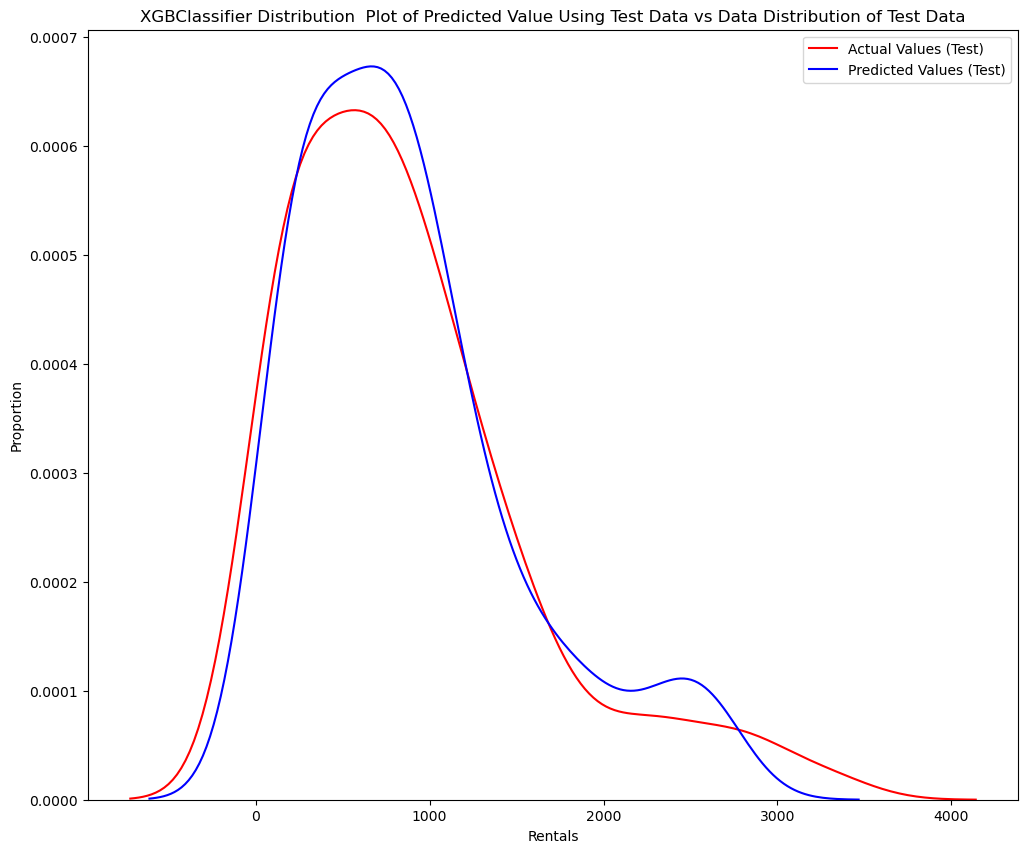

In [58]:
Title='XGBClassifier Distribution  Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,pred,"Actual Values (Test)","Predicted Values (Test)",Title)

In [59]:
# Model Evaluation Random Forest Regressor
predr = pipeline_rf.predict(x_test)

print("R^2:",metrics.r2_score(y_test, predr))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, predr))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, predr))
print("MSE:",metrics.mean_squared_error(y_test, predr))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, predr)))

R^2: 0.8524573624625562
Adjusted R^2: 0.843904166083574
MAE: 185.04986363636365
MSE: 75260.06688772728
RMSE: 274.33568285537933


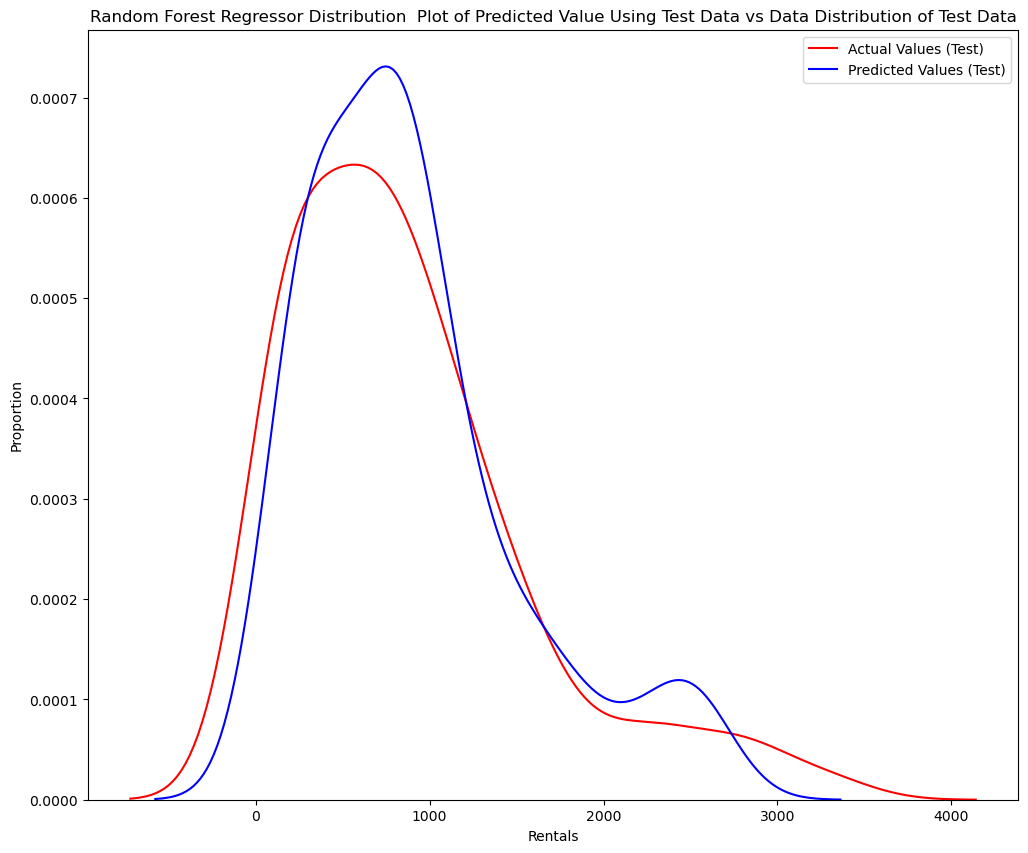

In [60]:
Title='Random Forest Regressor Distribution  Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,predr,"Actual Values (Test)","Predicted Values (Test)",Title)

In [61]:
# Model Evaluation Linear Regressor
predl = pipeline_lr.predict(x_test)

print("R^2:",metrics.r2_score(y_test, predl))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, predl))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, predl))
print("MSE:",metrics.mean_squared_error(y_test, predl))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, predl)))

R^2: 0.666130135236523
Adjusted R^2: 0.6467753604676257
MAE: 301.1301426248587
MSE: 170303.77640849014
RMSE: 412.67878114641434


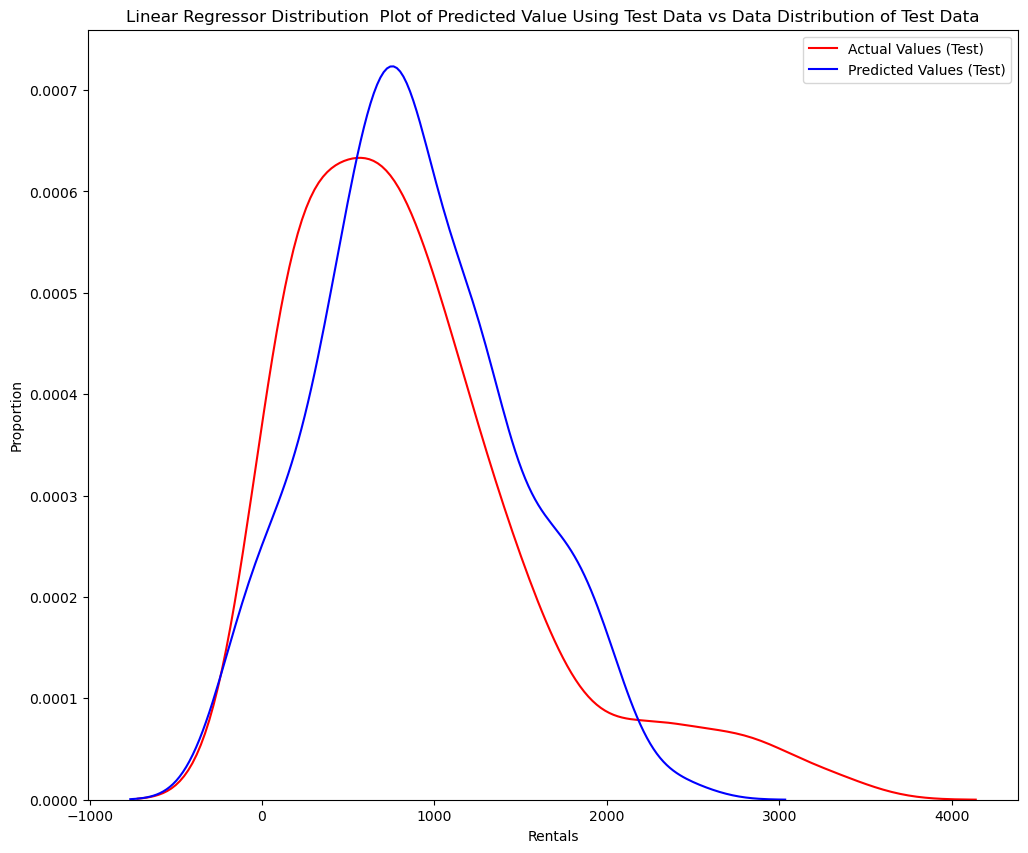

In [62]:
Title='Linear Regressor Distribution  Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,predl,"Actual Values (Test)","Predicted Values (Test)",Title)

In [63]:
# Model Evaluation for Decision Tree Regressor
predt =pipeline_dt.predict(x_test)

print("R^2:",metrics.r2_score(y_test, predt))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, predt))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, predt))
print("MSE:",metrics.mean_squared_error(y_test, predt))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, predt)))

R^2: 0.596719053151183
Adjusted R^2: 0.5733404475367588
MAE: 291.4136363636364
MSE: 205709.69545454546
RMSE: 453.55230729712474


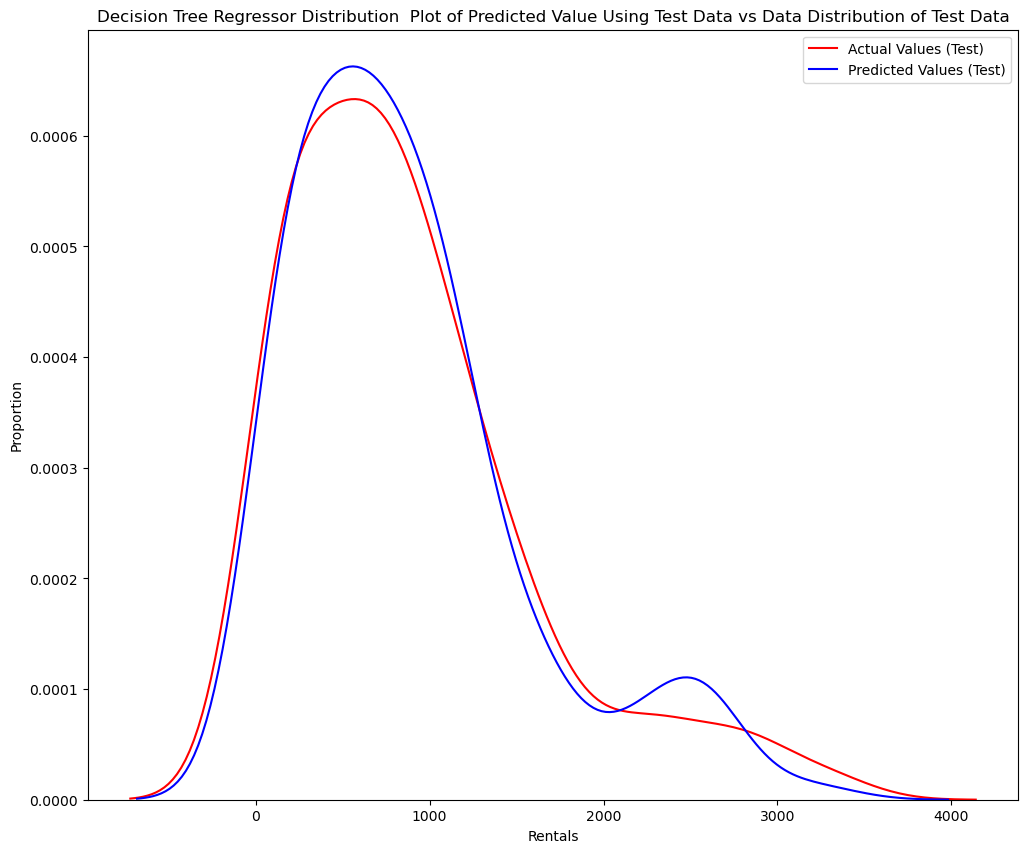

In [64]:
Title='Decision Tree Regressor Distribution  Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,predt,"Actual Values (Test)","Predicted Values (Test)",Title)

In [65]:
# Model Evaluation for K Neighbor Regressor
predk = pipeline_kn.predict(x_test)

print("R^2:",metrics.r2_score(y_test, predk))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, predk))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, predk))
print("MSE:",metrics.mean_squared_error(y_test, predk))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, predk)))

R^2: 0.761376437192766
Adjusted R^2: 0.7475431871749554
MAE: 248.77636363636364
MSE: 121719.56254545454
RMSE: 348.8833079203626


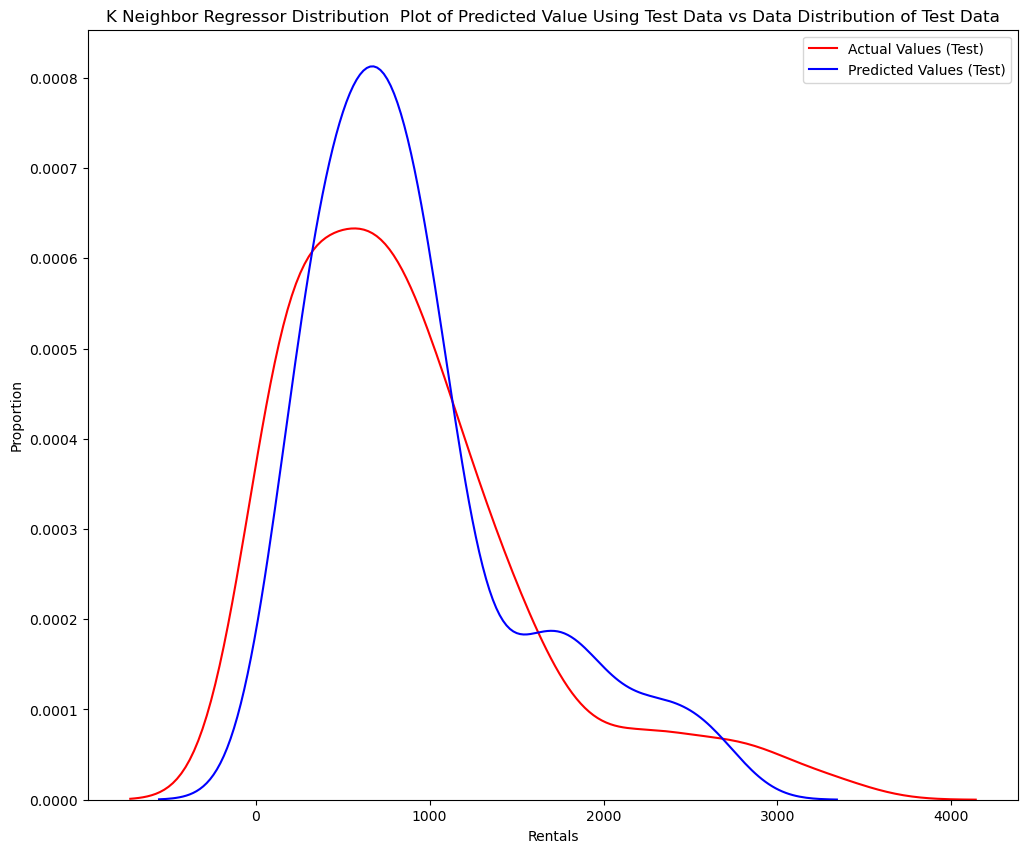

In [66]:
Title='K Neighbor Regressor Distribution  Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,predk,"Actual Values (Test)","Predicted Values (Test)",Title)

## R Scores
In all **XGBOOST REGRESSOR** and **RANDOM FOREST REGRESSOR** are of higher R SCORE and performed better